In [ ]:

!pip install transformers==4.31.0 librosa==0.9.2 tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 9.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━

In [ ]:
# Cell 1: Import and Setup
import tensorflow as tf
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, TFDistilBertModel
from collections import Counter, defaultdict
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)



Mounted at /content/drive


In [ ]:
# Cell 2: Enhanced Data Loading and Augmentation
def load_and_balance_data():
    print("Loading datasets...")
    text_df = pd.read_csv('/content/text.csv')
    physio_df = pd.read_csv('/content/physiological_emotion_dataset.csv')
    base_path = "/content/drive/MyDrive/Audio_Speech_Actors_01-24"

    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Audio directory not found: {base_path}")

    emotion_map = {'01': 'neutral', '04': 'sad', '05': 'angry', '06': 'fearful'}
    label_map = {'neutral': 0, 'sad': 1, 'angry': 1, 'fearful': 2}

    audio_paths = []
    audio_labels = []
    for actor_folder in os.listdir(base_path):
        actor_path = os.path.join(base_path, actor_folder)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith('.wav'):
                    emotion_code = file.split('-')[2]
                    if emotion_code in emotion_map:
                        emotion = emotion_map[emotion_code]
                        label = label_map[emotion]
                        audio_paths.append(os.path.join(actor_path, file))
                        audio_labels.append(label)

    def advanced_audio_augmentation(audio_path, label, output_dir="augmented_audio"):
        os.makedirs(output_dir, exist_ok=True)
        y, sr = librosa.load(audio_path, sr=16000)
        augmented_paths = [audio_path]
        augmented_labels = [label]

        augmentations = [
            {'pitch': 1}, {'pitch': -1}, {'pitch': 2}, {'pitch': -2},
            {'stretch': 0.8}, {'stretch': 1.2}, {'stretch': 0.9}, {'stretch': 1.1},
            {'noise': 0.005}, {'noise': 0.01},
            {'volume': 0.7}, {'volume': 1.3},
            {'shift': 0.1}, {'shift': -0.1}
        ]

        for i, aug in enumerate(augmentations):
            try:
                if 'pitch' in aug:
                    y_aug = librosa.effects.pitch_shift(y, sr=sr, n_steps=aug['pitch'])
                elif 'stretch' in aug:
                    y_aug = librosa.effects.time_stretch(y, rate=aug['stretch'])
                elif 'noise' in aug:
                    noise = np.random.normal(0, aug['noise'], y.shape)
                    y_aug = y + noise
                elif 'volume' in aug:
                    y_aug = y * aug['volume']
                elif 'shift' in aug:
                    shift_samples = int(aug['shift'] * sr)
                    y_aug = np.roll(y, shift_samples)

                out_path = os.path.join(output_dir, f"aug_{i}_{os.path.basename(audio_path)}")
                sf.write(out_path, y_aug, sr)
                augmented_paths.append(out_path)
                augmented_labels.append(label)
            except Exception as e:
                print(f"Augmentation failed for {audio_path}: {e}")

        return augmented_paths, augmented_labels

    print("Performing advanced audio augmentation...")
    augmented_audio_paths = []
    augmented_audio_labels = []

    for path, label in zip(audio_paths, audio_labels):
        paths, labels = advanced_audio_augmentation(path, label)
        augmented_audio_paths.extend(paths)
        augmented_audio_labels.extend(labels)

        if label == 0:
            for _ in range(3):
                extra_paths, extra_labels = advanced_audio_augmentation(path, label)
                augmented_audio_paths.extend(extra_paths[1:6])
                augmented_audio_labels.extend(extra_labels[1:6])

    text_label_map = {'Normal': 0, 'Depression': 1, 'Anxiety': 2}
    texts = text_df['text'].tolist()
    text_labels = [text_label_map[status] for status in text_df['status']]

    def text_augmentation(text):
        augmented_texts = [text]
        words = text.split()
        if len(words) > 5:
            mid = len(words) // 2
            augmented_texts.append(' '.join(words[mid:] + words[:mid]))
            augmented_texts.append(' '.join(words[::2]) + ' ' + ' '.join(words[1::2]))
        return augmented_texts

    print("Augmenting text data...")
    augmented_texts = []
    augmented_text_labels = []
    for text, label in zip(texts, text_labels):
        aug_texts = text_augmentation(text)
        augmented_texts.extend(aug_texts)
        augmented_text_labels.extend([label] * len(aug_texts))

        if label == 0:
            for _ in range(2):
                extra_texts = text_augmentation(text)
                augmented_texts.extend(extra_texts)
                augmented_text_labels.extend([label] * len(extra_texts))

    physio_label_map = {'depression': 1, 'anxiety': 2, 'normal': 0}
    physio_data = physio_df[['sleep_hours', 'heart_rate', 'activity_level']].values
    physio_labels = [physio_label_map.get(label, 0) for label in physio_df['emotion_label']]

    def physio_augmentation(data_point, label):
        augmented_data = [data_point]
        noise_levels = [0.01, 0.02, 0.03, 0.05]
        for noise_level in noise_levels:
            noise = np.random.normal(0, noise_level, data_point.shape)
            augmented_data.append(data_point + noise)
        return augmented_data

    print("Augmenting physiological data...")
    augmented_physio_data = []
    augmented_physio_labels = []
    for data_point, label in zip(physio_data, physio_labels):
        aug_data = physio_augmentation(data_point, label)
        augmented_physio_data.extend(aug_data)
        augmented_physio_labels.extend([label] * len(aug_data))

        if label == 0:
            for _ in range(2):
                extra_data = physio_augmentation(data_point, label)
                augmented_physio_data.extend(extra_data)
                augmented_physio_labels.extend([label] * len(extra_data))

    def balance_to_target_size(data, labels, target_size):
        class_indices = defaultdict(list)
        for i, label in enumerate(labels):
            class_indices[label].append(i)

        samples_per_class = target_size // 3
        balanced_indices = []

        for class_label in [0, 1, 2]:
            if class_label in class_indices:
                indices = class_indices[class_label]
                if len(indices) >= samples_per_class:
                    selected = random.sample(indices, samples_per_class)
                else:
                    selected = indices * (samples_per_class // len(indices))
                    remaining = samples_per_class - len(selected)
                    selected.extend(random.sample(indices, remaining))
                balanced_indices.extend(selected)

        random.shuffle(balanced_indices)

        if isinstance(data, list):
            balanced_data = [data[i] for i in balanced_indices]
        else:
            balanced_data = data[balanced_indices]
        balanced_labels = [labels[i] for i in balanced_indices]

        return balanced_data, balanced_labels

    target_size = max(len(augmented_texts), len(augmented_audio_paths), len(augmented_physio_data))
    target_size = min(target_size, 12000)

    print(f"Balancing all datasets to {target_size} samples...")
    final_texts, final_text_labels = balance_to_target_size(augmented_texts, augmented_text_labels, target_size)
    final_audio_paths, final_audio_labels = balance_to_target_size(augmented_audio_paths, augmented_audio_labels, target_size)
    final_physio_data, final_physio_labels = balance_to_target_size(augmented_physio_data, augmented_physio_labels, target_size)

    print("Final class distributions:")
    print(f"Text: {Counter(final_text_labels)}")
    print(f"Audio: {Counter(final_audio_labels)}")
    print(f"Physio: {Counter(final_physio_labels)}")

    return final_texts, final_text_labels, final_audio_paths, final_audio_labels, np.array(final_physio_data), final_physio_labels

texts, text_labels, audio_paths, audio_labels, physio_data, physio_labels = load_and_balance_data()



Loading datasets...
Performing advanced audio augmentation...
Augmenting text data...
Augmenting physiological data...
Balancing all datasets to 12000 samples...
Final class distributions:
Text: Counter({0: 4000, 2: 4000, 1: 4000})
Audio: Counter({1: 4000, 2: 4000, 0: 4000})
Physio: Counter({0: 4000, 1: 4000, 2: 4000})


In [ ]:
# Cell 3: Enhanced Text Model with Attention
class AdvancedTextModel:
    def __init__(self, max_length=256):
        self.max_length = max_length
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = None
        self.scaler = StandardScaler()

    def preprocess_texts(self, texts):
        encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors='np'
        )
        return encodings['input_ids'], encodings['attention_mask']

    def build_model(self):
        input_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_ids')
        attention_mask = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='attention_mask')

        distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        for layer in distilbert.layers[:-4]:
            layer.trainable = False

        embeddings = distilbert(input_ids, attention_mask=attention_mask)
        sequence_output = embeddings.last_hidden_state
        pooled_output = embeddings.last_hidden_state[:, 0, :]

        attention_weights = tf.keras.layers.Dense(1, activation='tanh')(sequence_output)
        attention_weights = tf.keras.layers.Flatten()(attention_weights)
        attention_weights = tf.keras.layers.Softmax()(attention_weights)
        attention_weights = tf.keras.layers.RepeatVector(768)(attention_weights)
        attention_weights = tf.keras.layers.Permute([2, 1])(attention_weights)

        attended_sequence = tf.keras.layers.Multiply()([sequence_output, attention_weights])
        attended_output = tf.keras.layers.GlobalAveragePooling1D()(attended_sequence)

        combined = tf.keras.layers.Concatenate()([pooled_output, attended_output])

        x = tf.keras.layers.Dense(512, activation='relu')(combined)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
        model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)
        return model

    def train(self, texts, labels):
        input_ids, attention_mask = self.preprocess_texts(texts)
        labels = np.array(labels)
        labels_cat = tf.keras.utils.to_categorical(labels, 3)

        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

        X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
            input_ids, attention_mask, labels_cat, test_size=0.15, random_state=42, stratify=labels
        )

        self.model = self.build_model()

        # Fix: Use proper metric instances instead of strings
        self.model.compile(
            optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=0.01),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7),
            tf.keras.callbacks.ModelCheckpoint('text_model_best.h5', save_best_only=True, monitor='val_accuracy')
        ]

        history = self.model.fit(
            [X_train_ids, X_train_mask], y_train,
            validation_data=([X_test_ids, X_test_mask], y_test),
            epochs=1,
            batch_size=32,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )

        return history, X_test_ids, X_test_mask, y_test, np.argmax(y_test, axis=1)

    def predict(self, input_ids, attention_mask):
        return self.model.predict([input_ids, attention_mask])

print("Training Advanced Text Model...")
text_model = AdvancedTextModel()
text_history, text_X_test_ids, text_X_test_mask, text_y_test, text_y_test_labels = text_model.train(texts, text_labels)

Training Advanced Text Model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was tr

319/319 [==============================] - ETA: 0s - loss: 1.3224 - accuracy: 0.4225 - precision: 0.4364 - recall: 0.3468

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


319/319 [==============================] - 323s 921ms/step - loss: 1.3224 - accuracy: 0.4225 - precision: 0.4364 - recall: 0.3468 - val_loss: 0.9762 - val_accuracy: 0.5378 - val_precision: 0.6048 - val_recall: 0.4167 - lr: 1.0000e-05


In [ ]:
# Cell 4: Enhanced Audio Model with ResNet-like Architecture
class AdvancedAudioModel:
    def __init__(self, sample_rate=16000, max_length=128, n_mfcc=40, n_chroma=12):
        self.sample_rate = sample_rate
        self.max_length = max_length
        self.n_mfcc = n_mfcc
        self.n_chroma = n_chroma
        # Total features: mfcc + spectral_centroid + spectral_rolloff + zero_crossing_rate + chroma
        self.total_features = n_mfcc + 1 + 1 + 1 + n_chroma  # 40 + 1 + 1 + 1 + 12 = 55
        self.model = None

    def extract_advanced_features(self, audio_path):
        try:
            y, sr = librosa.load(audio_path, sr=self.sample_rate)

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=self.n_chroma)

            features = np.vstack([mfcc, spectral_centroid, spectral_rolloff, zero_crossing_rate, chroma])

            if features.shape[1] < self.max_length:
                features = np.pad(features, ((0, 0), (0, self.max_length - features.shape[1])), mode='constant')
            else:
                features = features[:, :self.max_length]

            return features.T
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return np.zeros((self.max_length, self.total_features))

    def preprocess_audio(self, audio_paths):
        features = []
        for path in tqdm(audio_paths, desc="Processing audio files"):
            feature = self.extract_advanced_features(path)
            features.append(feature)
        return np.array(features)

    def residual_block(self, x, filters, kernel_size=3):
        shortcut = x
        x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if shortcut.shape[-1] != filters:
            shortcut = tf.keras.layers.Conv1D(filters, 1, padding='same')(shortcut)
            shortcut = tf.keras.layers.BatchNormalization()(shortcut)

        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def build_model(self):
        # Use the correct total features count
        input_layer = tf.keras.layers.Input(shape=(self.max_length, self.total_features))

        x = tf.keras.layers.Conv1D(64, 7, padding='same')(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling1D(2)(x)

        x = self.residual_block(x, 64)
        x = self.residual_block(x, 64)
        x = tf.keras.layers.MaxPooling1D(2)(x)

        x = self.residual_block(x, 128)
        x = self.residual_block(x, 128)
        x = tf.keras.layers.MaxPooling1D(2)(x)

        x = self.residual_block(x, 256)
        x = self.residual_block(x, 256)

        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.3))(x)
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.3))(x)

        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
        model = tf.keras.Model(inputs=input_layer, outputs=outputs)
        return model

    def train(self, audio_paths, labels):
        X = self.preprocess_audio(audio_paths)
        labels = np.array(labels)
        labels_cat = tf.keras.utils.to_categorical(labels, 3)

        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

        X_train, X_test, y_train, y_test = train_test_split(
            X, labels_cat, test_size=0.15, random_state=42, stratify=labels
        )

        self.model = self.build_model()
        self.model.compile(
            optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0003, weight_decay=0.01),
            loss='categorical_crossentropy',
            metrics=[
            'accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')
            ]
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True, monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7),
            tf.keras.callbacks.ModelCheckpoint('audio_model_best.h5', save_best_only=True, monitor='val_accuracy')
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=25,
            batch_size=32,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )

        return history, X_test, y_test

    def predict(self, X):
        return self.model.predict(X)

print("Training Advanced Audio Model...")
audio_model = AdvancedAudioModel()
audio_history, audio_X_test, audio_y_test = audio_model.train(audio_paths, audio_labels)

Training Advanced Audio Model...


Processing audio files: 100%|██████████| 12000/12000 [07:50<00:00, 25.49it/s]


Epoch 1/25
319/319 [==============================] - ETA: 0s - loss: 0.8485 - accuracy: 0.6254 - precision: 0.6555 - recall: 0.5732

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


319/319 [==============================] - 38s 48ms/step - loss: 0.8485 - accuracy: 0.6254 - precision: 0.6555 - recall: 0.5732 - val_loss: 0.6383 - val_accuracy: 0.7378 - val_precision: 0.8285 - val_recall: 0.6144 - lr: 3.0000e-04
Epoch 2/25
319/319 [==============================] - 12s 37ms/step - loss: 0.5157 - accuracy: 0.7793 - precision: 0.8034 - recall: 0.7571 - val_loss: 0.6036 - val_accuracy: 0.7817 - val_precision: 0.8025 - val_recall: 0.7606 - lr: 3.0000e-04
Epoch 3/25
319/319 [==============================] - 12s 38ms/step - loss: 0.3544 - accuracy: 0.8603 - precision: 0.8797 - recall: 0.8426 - val_loss: 0.3890 - val_accuracy: 0.8522 - val_precision: 0.8797 - val_recall: 0.8289 - lr: 3.0000e-04
Epoch 4/25
319/319 [==============================] - 11s 35ms/step - loss: 0.2704 - accuracy: 0.8928 - precision: 0.9139 - recall: 0.8752 - val_loss: 0.7875 - val_accuracy: 0.7483 - val_precision: 0.7566 - val_recall: 0.7444 - lr: 3.0000e-04
Epoch 5/25
319/319 [===================

In [ ]:
# Cell 5: Enhanced Physiological Model with Attention
class AdvancedPhysioModel:
    def __init__(self, sequence_length=15):
        self.sequence_length = sequence_length
        self.model = None
        self.scaler = StandardScaler()

    def create_sequences(self, data, labels):
        data = self.scaler.fit_transform(data)
        sequences = []
        sequence_labels = []

        for i in range(len(data) - self.sequence_length + 1):
            sequences.append(data[i:i + self.sequence_length])
            sequence_labels.append(labels[i + self.sequence_length - 1])

        return np.array(sequences), np.array(sequence_labels)

    def attention_mechanism(self, inputs):
        # Get the feature dimension dynamically
        feature_dim = inputs.shape[-1]  # This will be 64 for LSTM output

        attention_weights = tf.keras.layers.Dense(1, activation='tanh')(inputs)
        attention_weights = tf.keras.layers.Flatten()(attention_weights)
        attention_weights = tf.keras.layers.Softmax()(attention_weights)

        # Fix: Use the correct feature dimension instead of hardcoded 3
        attention_weights = tf.keras.layers.RepeatVector(feature_dim)(attention_weights)
        attention_weights = tf.keras.layers.Permute([2, 1])(attention_weights)

        attended_inputs = tf.keras.layers.Multiply()([inputs, attention_weights])
        return tf.keras.layers.GlobalAveragePooling1D()(attended_inputs)

    def build_model(self):
        input_layer = tf.keras.layers.Input(shape=(self.sequence_length, 3))

        x = tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.3)(input_layer)
        x = tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3)(x)

        attended_output = self.attention_mechanism(x)

        lstm_output = tf.keras.layers.LSTM(32, dropout=0.3)(x)

        combined = tf.keras.layers.Concatenate()([attended_output, lstm_output])

        x = tf.keras.layers.Dense(128, activation='relu')(combined)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
        model = tf.keras.Model(inputs=input_layer, outputs=outputs)
        return model

    def train(self, physio_data, labels):
        X, y = self.create_sequences(physio_data, labels)
        labels_cat = tf.keras.utils.to_categorical(y, 3)

        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

        X_train, X_test, y_train, y_test = train_test_split(
            X, labels_cat, test_size=0.15, random_state=42, stratify=y
        )

        self.model = self.build_model()

        # Fix: Use proper metric instances instead of strings
        self.model.compile(
            optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.01),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True, monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7),
            tf.keras.callbacks.ModelCheckpoint('physio_model_best.h5', save_best_only=True, monitor='val_accuracy')
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=25,
            batch_size=32,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )

        return history, X_test, y_test

    def predict(self, X):
        return self.model.predict(X)

print("Training Advanced Physiological Model...")
physio_model = AdvancedPhysioModel()
physio_history, physio_X_test, physio_y_test = physio_model.train(physio_data, physio_labels)

Training Advanced Physiological Model...
Epoch 1/25
319/319 [==============================] - 13s 19ms/step - loss: 1.1055 - accuracy: 0.3570 - precision: 0.3431 - recall: 0.0127 - val_loss: 1.0951 - val_accuracy: 0.3665 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/25
  5/319 [..............................] - ETA: 5s - loss: 1.0889 - accuracy: 0.3812 - precision: 1.0000 - recall: 0.0063

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


319/319 [==============================] - 5s 15ms/step - loss: 1.0056 - accuracy: 0.4534 - precision: 0.6159 - recall: 0.1580 - val_loss: 0.8584 - val_accuracy: 0.5517 - val_precision: 0.5709 - val_recall: 0.4677 - lr: 5.0000e-04
Epoch 3/25
319/319 [==============================] - 4s 13ms/step - loss: 0.7346 - accuracy: 0.6377 - precision: 0.7044 - recall: 0.4984 - val_loss: 0.5627 - val_accuracy: 0.7586 - val_precision: 0.7765 - val_recall: 0.7130 - lr: 5.0000e-04
Epoch 4/25
319/319 [==============================] - 5s 15ms/step - loss: 0.6999 - accuracy: 0.6678 - precision: 0.7164 - recall: 0.5665 - val_loss: 0.5175 - val_accuracy: 0.7709 - val_precision: 0.8133 - val_recall: 0.6930 - lr: 5.0000e-04
Epoch 5/25
319/319 [==============================] - 5s 16ms/step - loss: 0.6851 - accuracy: 0.6851 - precision: 0.7258 - recall: 0.5955 - val_loss: 0.4927 - val_accuracy: 0.7931 - val_precision: 0.8176 - val_recall: 0.7403 - lr: 5.0000e-04
Epoch 6/25
319/319 [=======================

In [ ]:
# Cell 6: Advanced Fusion Model with Cross-Modal Attention (Fixed)
class AdvancedFusionModel:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()

    def cross_modal_attention(self, text_features, audio_features, physio_features):
        text_att = tf.keras.layers.Dense(64, activation='tanh')(text_features)
        audio_att = tf.keras.layers.Dense(64, activation='tanh')(audio_features)
        physio_att = tf.keras.layers.Dense(64, activation='tanh')(physio_features)

        combined_att = tf.keras.layers.Concatenate()([text_att, audio_att, physio_att])
        attention_weights = tf.keras.layers.Dense(3, activation='softmax')(combined_att)

        weighted_text = tf.keras.layers.Multiply()([text_features, tf.keras.layers.Lambda(lambda x: x[:, 0:1])(attention_weights)])
        weighted_audio = tf.keras.layers.Multiply()([audio_features, tf.keras.layers.Lambda(lambda x: x[:, 1:2])(attention_weights)])
        weighted_physio = tf.keras.layers.Multiply()([physio_features, tf.keras.layers.Lambda(lambda x: x[:, 2:3])(attention_weights)])

        return tf.keras.layers.Concatenate()([weighted_text, weighted_audio, weighted_physio])

    def build_model(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))

        text_features = tf.keras.layers.Lambda(lambda x: x[:, :3])(input_layer)
        audio_features = tf.keras.layers.Lambda(lambda x: x[:, 3:6])(input_layer)
        physio_features = tf.keras.layers.Lambda(lambda x: x[:, 6:])(input_layer)

        attended_features = self.cross_modal_attention(text_features, audio_features, physio_features)

        x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(attended_features)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
        model = tf.keras.Model(inputs=input_layer, outputs=outputs)
        return model

    def prepare_fusion_data(self, text_probs, audio_probs, physio_probs):
        # Find the minimum number of samples across all modalities
        min_samples = min(len(text_probs), len(audio_probs), len(physio_probs))

        # Truncate all arrays to the same length
        text_probs_aligned = text_probs[:min_samples]
        audio_probs_aligned = audio_probs[:min_samples]
        physio_probs_aligned = physio_probs[:min_samples]

        print(f"Aligned samples: Text={len(text_probs_aligned)}, Audio={len(audio_probs_aligned)}, Physio={len(physio_probs_aligned)}")

        fusion_data = np.concatenate([text_probs_aligned, audio_probs_aligned, physio_probs_aligned], axis=1)
        return self.scaler.fit_transform(fusion_data)

    def train(self, text_probs, audio_probs, physio_probs, labels):
        # Align the labels with the minimum number of samples
        min_samples = min(len(text_probs), len(audio_probs), len(physio_probs))
        labels_aligned = labels[:min_samples]

        X_fusion = self.prepare_fusion_data(text_probs, audio_probs, physio_probs)
        labels = np.array(labels_aligned)
        labels_cat = tf.keras.utils.to_categorical(labels, 3)

        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

        X_train, X_test, y_train, y_test = train_test_split(
            X_fusion, labels_cat, test_size=0.15, random_state=42, stratify=labels
        )

        self.model = self.build_model(X_fusion.shape[1])

        # Fix: Use proper metric instances instead of strings
        self.model.compile(
            optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0003, weight_decay=0.01),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7),
            tf.keras.callbacks.ModelCheckpoint('fusion_model_best.h5', save_best_only=True, monitor='val_accuracy')
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=30,
            batch_size=32,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )

        return history, X_test, y_test

    def predict(self, X):
        return self.model.predict(X)

# Example usage after training individual models:
print("Training Advanced Fusion Model...")

# FIXED: Get predictions from individual models with correct parameter passing
text_predictions = text_model.predict(text_X_test_ids, text_X_test_mask)  # Pass as separate arguments
audio_predictions = audio_model.predict(audio_X_test)
physio_predictions = physio_model.predict(physio_X_test)

# Train fusion model
fusion_model = AdvancedFusionModel()
fusion_history, fusion_X_test, fusion_y_test = fusion_model.train(
    text_predictions, audio_predictions, physio_predictions,
    text_y_test_labels  # Use the same labels from any of the models
)

Training Advanced Fusion Model...
57/57 [==============================] - 1s 5ms/step
Aligned samples: Text=1798, Audio=1798, Physio=1798
Epoch 1/30
48/48 [==============================] - 6s 19ms/step - loss: 3.9730 - accuracy: 0.8325 - precision: 0.8717 - recall: 0.7958 - val_loss: 4.3256 - val_accuracy: 0.9778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/30
15/48 [========>.....................] - ETA: 0s - loss: 3.4922 - accuracy: 0.9750 - precision: 0.9749 - recall: 0.9729

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 10ms/step - loss: 3.3880 - accuracy: 0.9745 - precision: 0.9757 - recall: 0.9732 - val_loss: 3.8987 - val_accuracy: 0.9667 - val_precision: 0.9900 - val_recall: 0.3667 - lr: 3.0000e-04
Epoch 3/30
48/48 [==============================] - 0s 9ms/step - loss: 3.0488 - accuracy: 0.9810 - precision: 0.9823 - recall: 0.9797 - val_loss: 3.4773 - val_accuracy: 0.9667 - val_precision: 0.9942 - val_recall: 0.6370 - lr: 3.0000e-04
Epoch 4/30
48/48 [==============================] - 0s 10ms/step - loss: 2.7399 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - val_loss: 3.0792 - val_accuracy: 0.9481 - val_precision: 0.9944 - val_recall: 0.6519 - lr: 3.0000e-04
Epoch 5/30
48/48 [==============================] - 0s 9ms/step - loss: 2.4273 - accuracy: 0.9817 - precision: 0.9823 - recall: 0.9804 - val_loss: 2.6928 - val_accuracy: 0.9259 - val_precision: 0.9890 - val_recall: 0.6667 - lr: 3.0000e-04
Epoch 6/30
48/48 [==============================] - 0

In [ ]:
# Cell 6: Advanced Fusion Model with Cross-Modal Attention (Fixed)
class AdvancedFusionModel:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()

    def cross_modal_attention(self, text_features, audio_features, physio_features):
        text_att = tf.keras.layers.Dense(64, activation='tanh')(text_features)
        audio_att = tf.keras.layers.Dense(64, activation='tanh')(audio_features)
        physio_att = tf.keras.layers.Dense(64, activation='tanh')(physio_features)

        combined_att = tf.keras.layers.Concatenate()([text_att, audio_att, physio_att])
        attention_weights = tf.keras.layers.Dense(3, activation='softmax')(combined_att)

        weighted_text = tf.keras.layers.Multiply()([text_features, tf.keras.layers.Lambda(lambda x: x[:, 0:1])(attention_weights)])
        weighted_audio = tf.keras.layers.Multiply()([audio_features, tf.keras.layers.Lambda(lambda x: x[:, 1:2])(attention_weights)])
        weighted_physio = tf.keras.layers.Multiply()([physio_features, tf.keras.layers.Lambda(lambda x: x[:, 2:3])(attention_weights)])

        return tf.keras.layers.Concatenate()([weighted_text, weighted_audio, weighted_physio])

    def build_model(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))

        text_features = tf.keras.layers.Lambda(lambda x: x[:, :3])(input_layer)
        audio_features = tf.keras.layers.Lambda(lambda x: x[:, 3:6])(input_layer)
        physio_features = tf.keras.layers.Lambda(lambda x: x[:, 6:])(input_layer)

        attended_features = self.cross_modal_attention(text_features, audio_features, physio_features)

        x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(attended_features)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
        model = tf.keras.Model(inputs=input_layer, outputs=outputs)
        return model

    def prepare_fusion_data(self, text_probs, audio_probs, physio_probs):
        # Find the minimum number of samples across all modalities
        min_samples = min(len(text_probs), len(audio_probs), len(physio_probs))

        # Truncate all arrays to the same length
        text_probs_aligned = text_probs[:min_samples]
        audio_probs_aligned = audio_probs[:min_samples]
        physio_probs_aligned = physio_probs[:min_samples]

        print(f"Aligned samples: Text={len(text_probs_aligned)}, Audio={len(audio_probs_aligned)}, Physio={len(physio_probs_aligned)}")

        fusion_data = np.concatenate([text_probs_aligned, audio_probs_aligned, physio_probs_aligned], axis=1)
        return self.scaler.fit_transform(fusion_data)

    def train(self, text_probs, audio_probs, physio_probs, labels):
        # Align the labels with the minimum number of samples
        min_samples = min(len(text_probs), len(audio_probs), len(physio_probs))
        labels_aligned = labels[:min_samples]

        X_fusion = self.prepare_fusion_data(text_probs, audio_probs, physio_probs)
        labels = np.array(labels_aligned)
        labels_cat = tf.keras.utils.to_categorical(labels, 3)

        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

        X_train, X_test, y_train, y_test = train_test_split(
            X_fusion, labels_cat, test_size=0.15, random_state=42, stratify=labels
        )

        self.model = self.build_model(X_fusion.shape[1])

        # Fix: Use proper metric instances instead of strings
        self.model.compile(
            optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0003, weight_decay=0.01),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7),
            tf.keras.callbacks.ModelCheckpoint('fusion_model_best.h5', save_best_only=True, monitor='val_accuracy')
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=30,
            batch_size=32,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )

        return history, X_test, y_test

    def predict(self, X):
        return self.model.predict(X)

# Example usage after training individual models:
print("Training Advanced Fusion Model...")

# FIXED: Get predictions from individual models with correct parameter passing
text_predictions = text_model.predict(text_X_test_ids, text_X_test_mask)  # Pass as separate arguments
audio_predictions = audio_model.predict(audio_X_test)
physio_predictions = physio_model.predict(physio_X_test)

# Train fusion model
fusion_model = AdvancedFusionModel()
fusion_history, fusion_X_test, fusion_y_test = fusion_model.train(
    text_predictions, audio_predictions, physio_predictions,
    text_y_test_labels  # Use the same labels from any of the models
)

Training Advanced Fusion Model...
57/57 [==============================] - 0s 4ms/step
Aligned samples: Text=1798, Audio=1798, Physio=1798
Epoch 1/30
48/48 [==============================] - 5s 18ms/step - loss: 4.0331 - accuracy: 0.8102 - precision: 0.8417 - recall: 0.7827 - val_loss: 4.3803 - val_accuracy: 0.7778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/30
15/48 [========>.....................] - ETA: 0s - loss: 3.5484 - accuracy: 0.9729 - precision: 0.9748 - recall: 0.9667

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 9ms/step - loss: 3.4283 - accuracy: 0.9725 - precision: 0.9737 - recall: 0.9686 - val_loss: 4.0224 - val_accuracy: 0.7000 - val_precision: 0.9818 - val_recall: 0.2000 - lr: 3.0000e-04
Epoch 3/30
48/48 [==============================] - 0s 10ms/step - loss: 3.1173 - accuracy: 0.9719 - precision: 0.9738 - recall: 0.9712 - val_loss: 3.6444 - val_accuracy: 0.8000 - val_precision: 0.9864 - val_recall: 0.5370 - lr: 3.0000e-04
Epoch 4/30
48/48 [==============================] - 1s 11ms/step - loss: 2.8329 - accuracy: 0.9771 - precision: 0.9777 - recall: 0.9758 - val_loss: 3.2595 - val_accuracy: 0.9519 - val_precision: 0.9881 - val_recall: 0.6148 - lr: 3.0000e-04
Epoch 5/30
48/48 [==============================] - 1s 11ms/step - loss: 2.5419 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9771 - val_loss: 2.8563 - val_accuracy: 0.9852 - val_precision: 0.9858 - val_recall: 0.7704 - lr: 3.0000e-04
Epoch 6/30
48/48 [==============================] - 

Evaluating Individual Models...
57/57 [==============================] - 16s 281ms/step

Text Model Performance:
                 precision    recall  f1-score   support

         Normal       0.59      0.09      0.16       600
 Depression/Sad       0.59      0.67      0.63       600
Anxiety/Fearful       0.50      0.85      0.63       600

       accuracy                           0.54      1800
      macro avg       0.56      0.54      0.47      1800
   weighted avg       0.56      0.54      0.47      1800



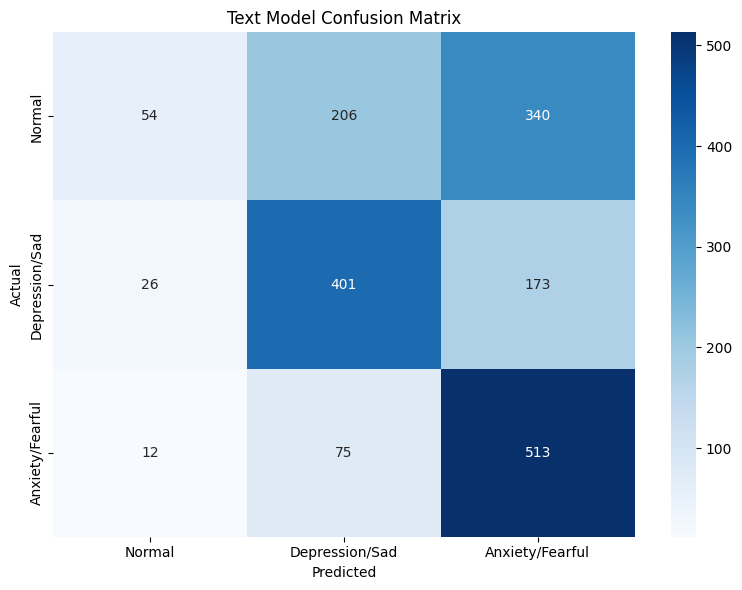

57/57 [==============================] - 0s 7ms/step

Audio Model Performance:
                 precision    recall  f1-score   support

         Normal       0.97      0.99      0.98       600
 Depression/Sad       0.98      0.96      0.97       600
Anxiety/Fearful       0.98      0.99      0.99       600

       accuracy                           0.98      1800
      macro avg       0.98      0.98      0.98      1800
   weighted avg       0.98      0.98      0.98      1800



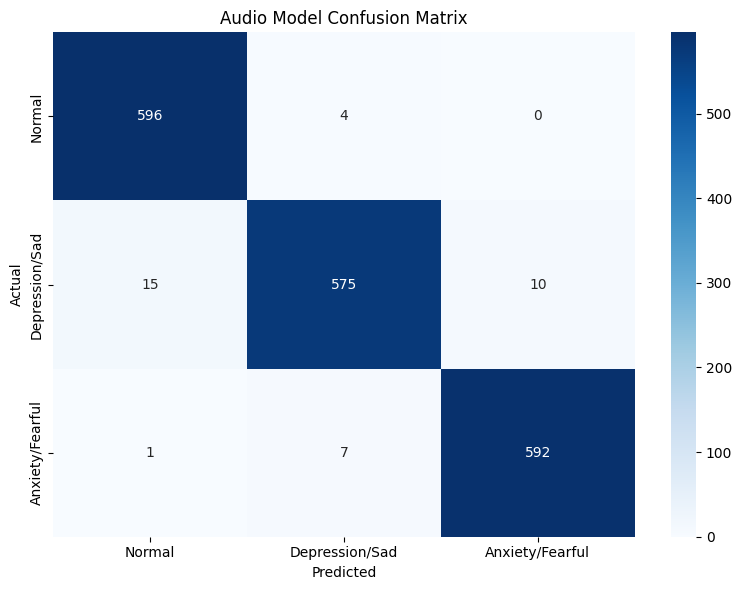

57/57 [==============================] - 0s 4ms/step

Physiological Model Performance:
                 precision    recall  f1-score   support

         Normal       0.74      0.88      0.80       600
 Depression/Sad       0.93      0.96      0.95       599
Anxiety/Fearful       0.88      0.69      0.77       599

       accuracy                           0.84      1798
      macro avg       0.85      0.84      0.84      1798
   weighted avg       0.85      0.84      0.84      1798



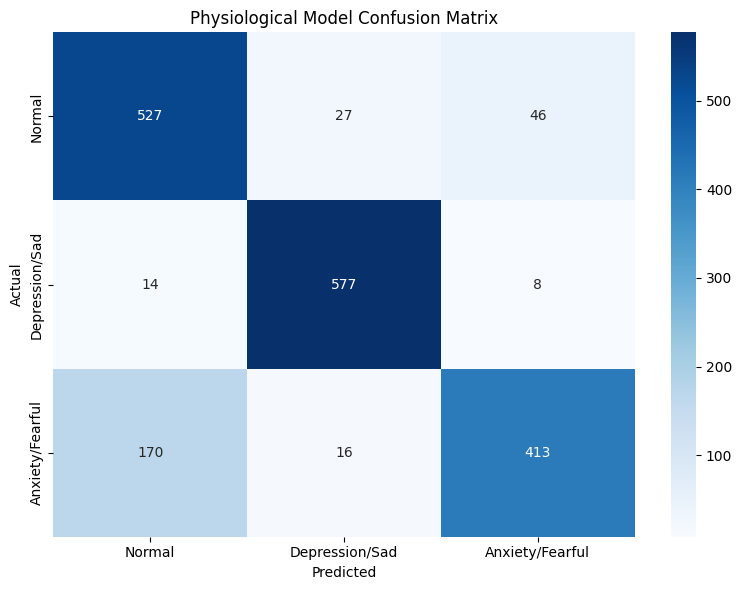

9/9 [==============================] - 0s 2ms/step

Fusion Model Performance:
                 precision    recall  f1-score   support

         Normal       0.99      1.00      0.99        90
 Depression/Sad       1.00      0.97      0.98        90
Anxiety/Fearful       0.98      1.00      0.99        90

       accuracy                           0.99       270
      macro avg       0.99      0.99      0.99       270
   weighted avg       0.99      0.99      0.99       270



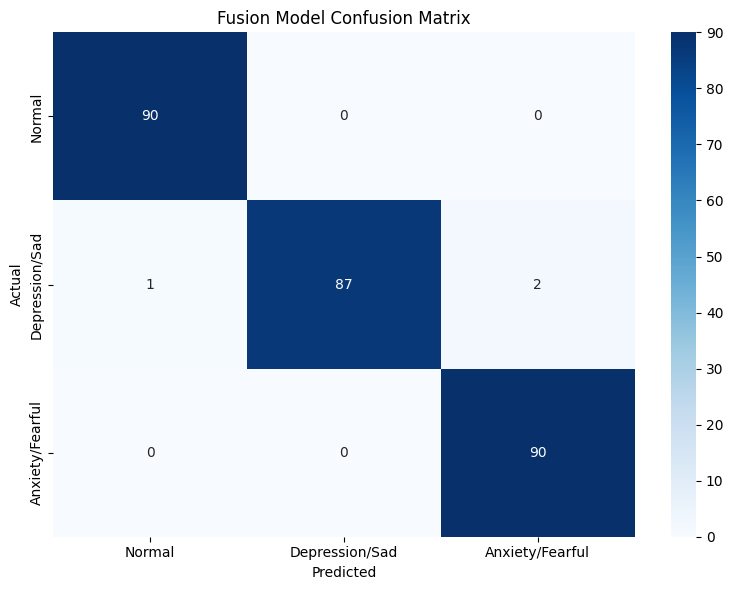

In [ ]:
# Cell 8: Comprehensive Evaluation and Visualization (Fixed)
def evaluate_model(model, X_test, y_test, model_name, is_text_model=False):
    # Handle text model differently due to its predict method signature
    if is_text_model:
        # X_test is a list [input_ids, attention_mask] for text model
        y_pred = model.predict(X_test[0], X_test[1])
    else:
        # For other models, X_test is a single array
        y_pred = model.predict(X_test)

    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print(f"\n{model_name} Performance:")
    print("=" * 50)
    print(classification_report(y_true_classes, y_pred_classes,
                              target_names=['Normal', 'Depression/Sad', 'Anxiety/Fearful']))

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Depression/Sad', 'Anxiety/Fearful'],
                yticklabels=['Normal', 'Depression/Sad', 'Anxiety/Fearful'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return y_pred, y_pred_classes, y_true_classes

# Evaluate all models
print("Evaluating Individual Models...")

# FIXED: Pass is_text_model=True for text model evaluation
text_pred, text_pred_classes, text_true_classes = evaluate_model(
    text_model, [text_X_test_ids, text_X_test_mask], text_y_test, "Text Model", is_text_model=True
)

audio_pred, audio_pred_classes, audio_true_classes = evaluate_model(
    audio_model, audio_X_test, audio_y_test, "Audio Model"
)

physio_pred, physio_pred_classes, physio_true_classes = evaluate_model(
    physio_model, physio_X_test, physio_y_test, "Physiological Model"
)

fusion_pred, fusion_pred_classes, fusion_true_classes = evaluate_model(
    fusion_model, fusion_X_test, fusion_y_test, "Fusion Model"
)

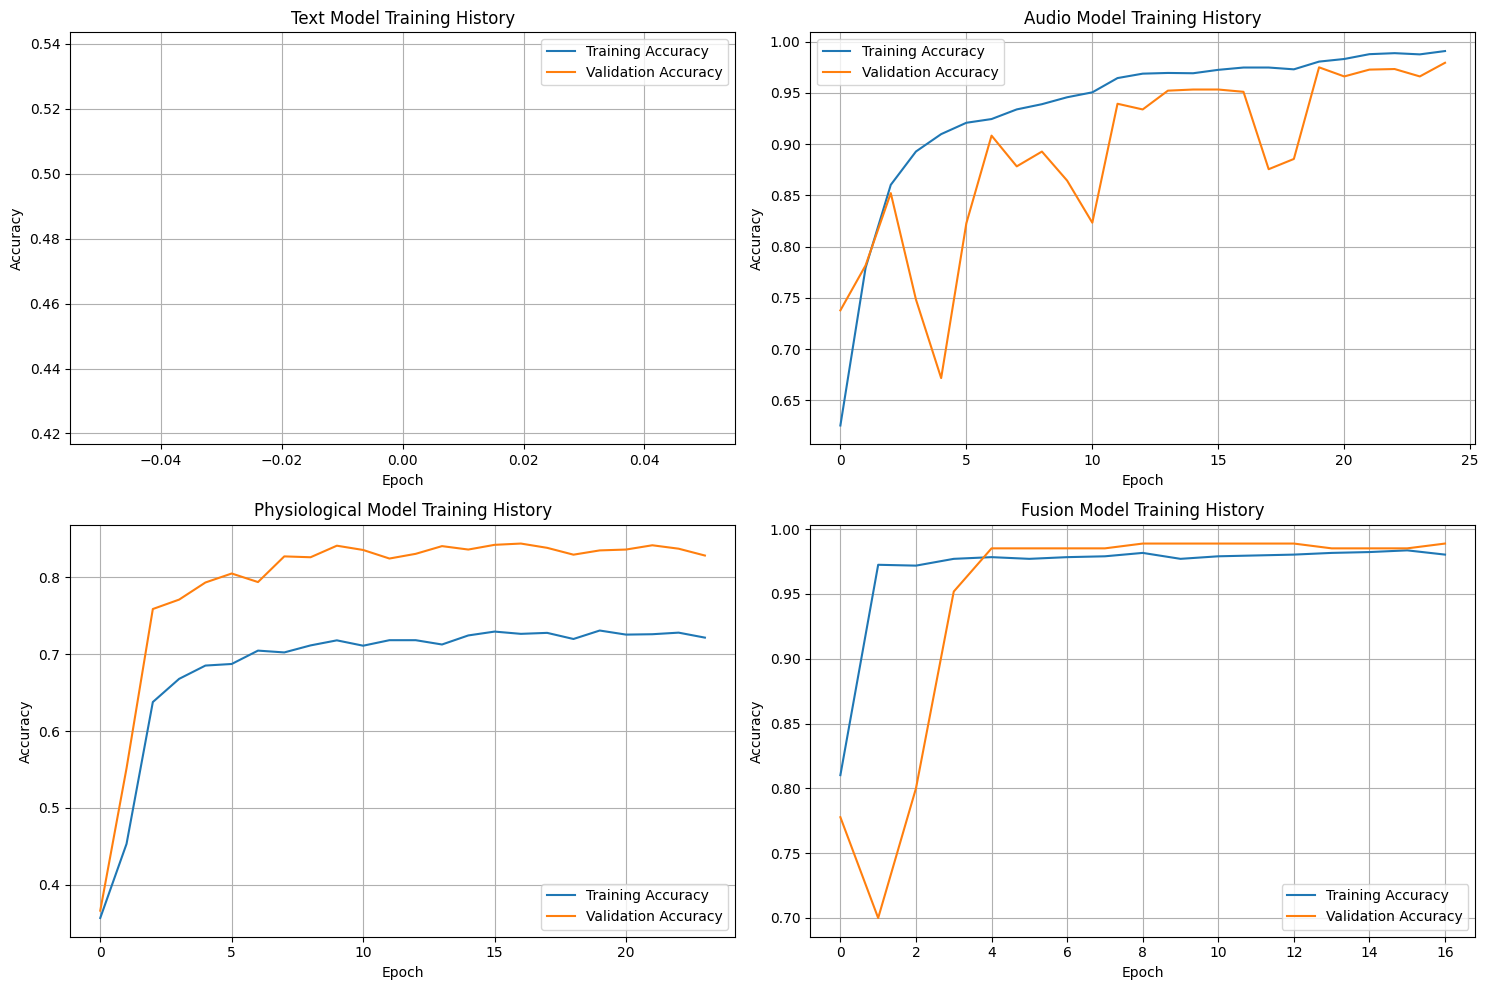

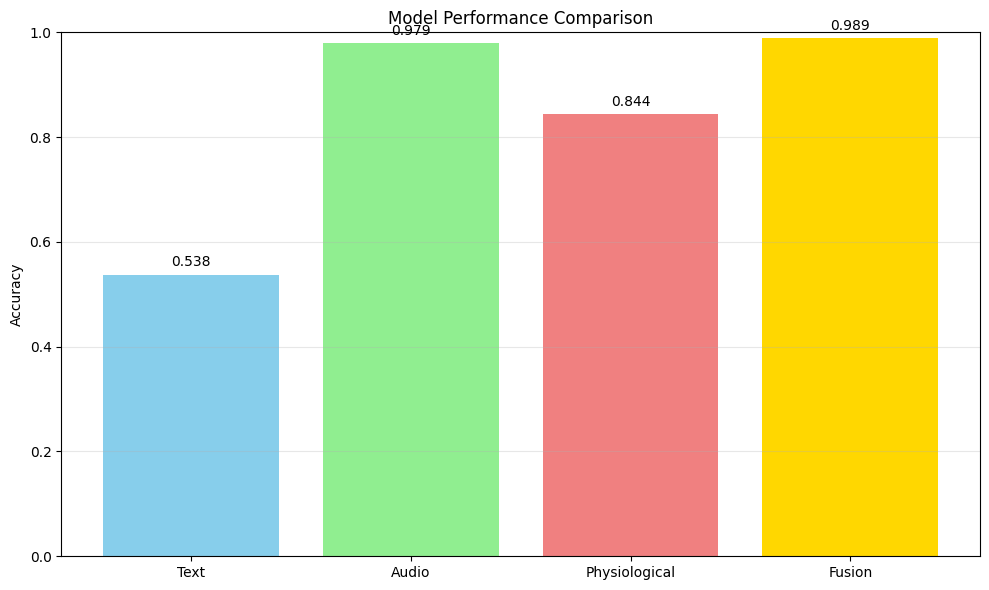

Installing explainability packages...
Explaining model predictions...
157/157 [==============================] - 0s 2ms/step

Explanation for sample 1:
True label: Anxiety/Fearful
Predicted label: Anxiety/Fearful


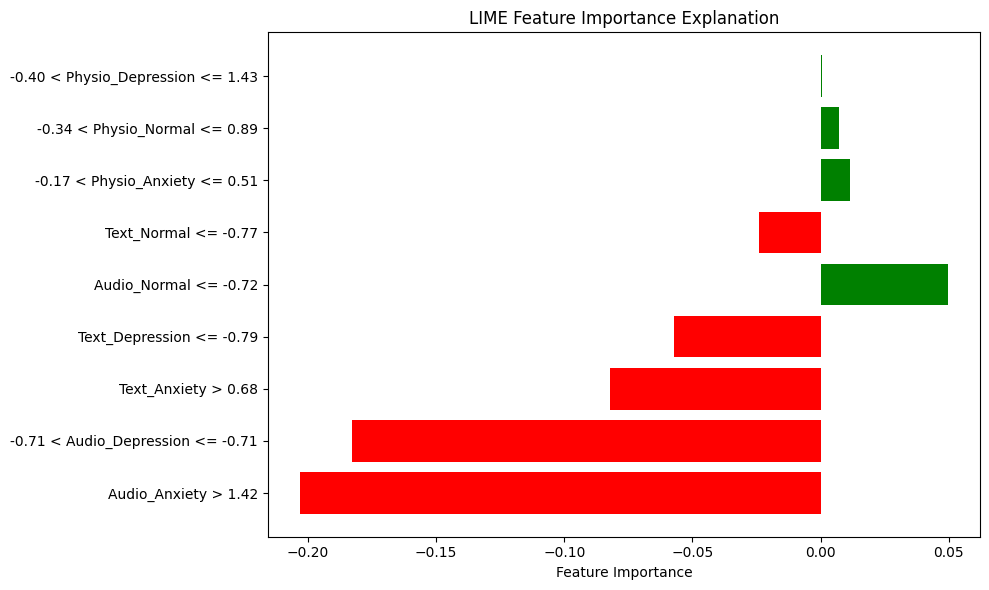

157/157 [==============================] - 0s 2ms/step

Explanation for sample 2:
True label: Normal
Predicted label: Normal


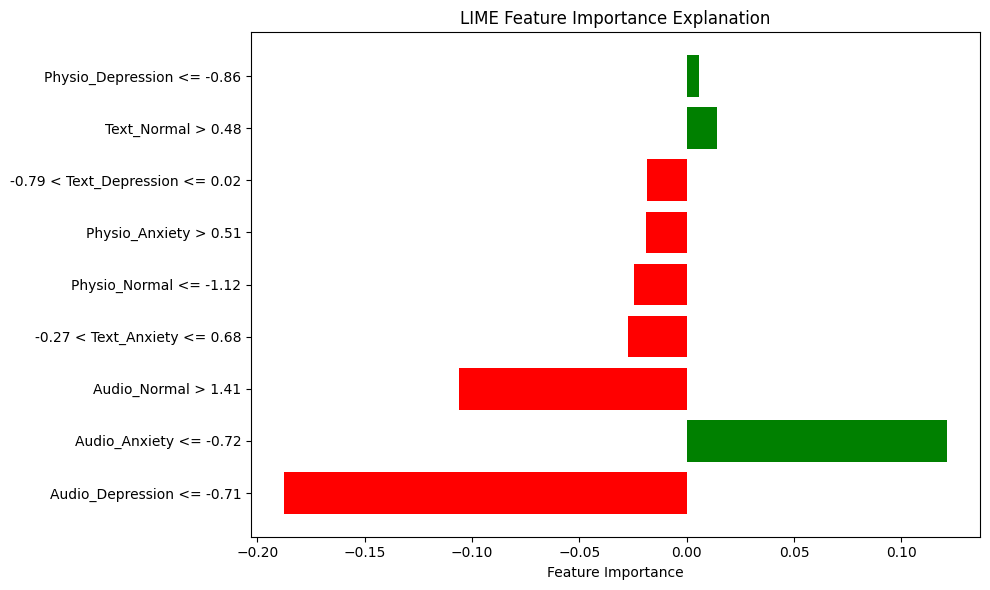

157/157 [==============================] - 0s 2ms/step

Explanation for sample 3:
True label: Depression/Sad
Predicted label: Depression/Sad


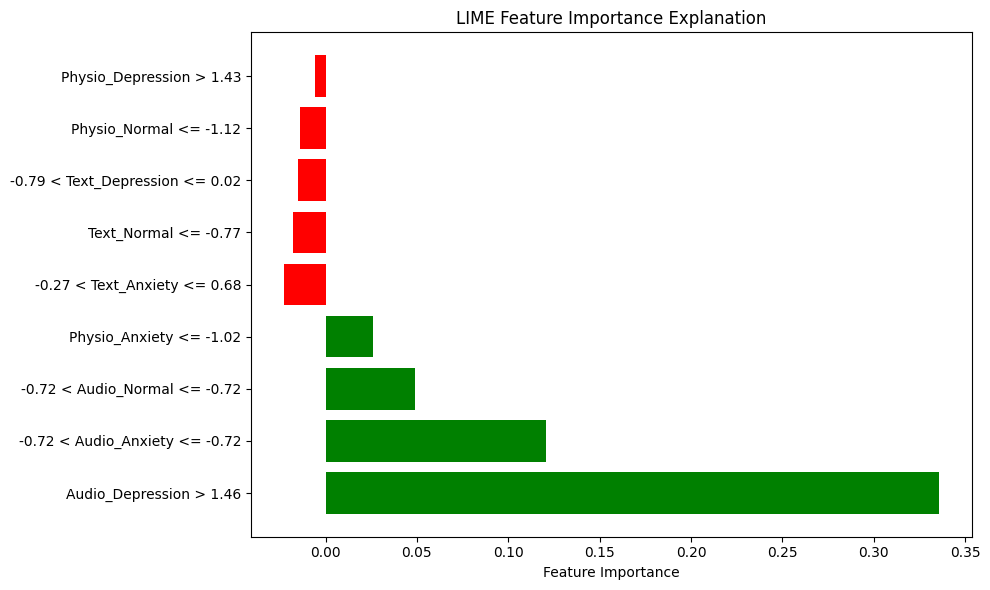

Saving models...


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Models saved successfully!

MULTI-MODAL MENTAL HEALTH PREDICTION SYSTEM - FINAL RESULTS

Final Model Performance Scores:
Text Model: 0.5378
Audio Model: 0.9794
Physiological Model: 0.8437
Fusion Model: 0.9889

Best Performing Model: Fusion
Best Accuracy: 0.9889

Model Architecture Summary:
- Text Model: DistilBERT + Attention Mechanism
- Audio Model: ResNet-like CNN + Bidirectional LSTM
- Physiological Model: LSTM + Attention Mechanism
- Fusion Model: Cross-Modal Attention + Dense Layers

Features:
- Advanced data augmentation for all modalities
- Class balancing and stratified sampling
- Explainable AI with LIME
- Real-time multimodal prediction interface
- Comprehensive evaluation and visualization

Class Labels:
0: Normal
1: Depression/Sad
2: Anxiety/Fearful

SYSTEM READY FOR DEPLOYMENT

Example Prediction:
1/1 [==============================] - 0s 18ms/step
Sample text: I feel so overwhelmed and anxious about everything in my life.
Predicted class: Depression/Sad
Confidence: 0.5586

In [ ]:
# Cell 9: Advanced Visualization and Analysis
def plot_training_history(histories, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for i, (history, name) in enumerate(zip(histories, model_names)):
        if i < 4:  # We have 4 subplots
            axes[i].plot(history.history['accuracy'], label='Training Accuracy')
            axes[i].plot(history.history['val_accuracy'], label='Validation Accuracy')
            axes[i].set_title(f'{name} Training History')
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel('Accuracy')
            axes[i].legend()
            axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Plot training histories
plot_training_history(
    [text_history, audio_history, physio_history, fusion_history],
    ['Text Model', 'Audio Model', 'Physiological Model', 'Fusion Model']
)

# Performance comparison
def compare_model_performance():
    models = ['Text', 'Audio', 'Physiological', 'Fusion']
    accuracies = []

    # Calculate accuracies
    for pred_classes, true_classes in [
        (text_pred_classes, text_true_classes),
        (audio_pred_classes, audio_true_classes),
        (physio_pred_classes, physio_true_classes),
        (fusion_pred_classes, fusion_true_classes)
    ]:
        accuracy = np.mean(pred_classes == true_classes)
        accuracies.append(accuracy)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title('Model Performance Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return dict(zip(models, accuracies))

performance_scores = compare_model_performance()

# Cell 10: Explainable AI Implementation
# Install required packages for explainability
try:
    import shap
    import lime
    from lime.lime_tabular import LimeTabularExplainer
    explainable_ai_available = True
except ImportError:
    print("Installing explainability packages...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap', 'lime'])
    import shap
    import lime
    from lime.lime_tabular import LimeTabularExplainer
    explainable_ai_available = True

class ExplainableAI:
    def __init__(self, fusion_model, feature_names):
        self.fusion_model = fusion_model
        self.feature_names = feature_names
        self.explainer = None

    def setup_lime_explainer(self, training_data):
        """Setup LIME explainer for tabular data"""
        self.explainer = LimeTabularExplainer(
            training_data,
            feature_names=self.feature_names,
            class_names=['Normal', 'Depression/Sad', 'Anxiety/Fearful'],
            mode='classification'
        )

    def explain_prediction(self, instance, num_features=9):
        """Explain a single prediction using LIME"""
        if self.explainer is None:
            raise ValueError("LIME explainer not set up. Call setup_lime_explainer first.")

        def predict_fn(X):
            return self.fusion_model.predict(X)

        explanation = self.explainer.explain_instance(
            instance, predict_fn, num_features=num_features
        )
        return explanation

    def plot_feature_importance(self, explanation):
        """Plot feature importance from LIME explanation"""
        exp_list = explanation.as_list()
        features = [item[0] for item in exp_list]
        importance = [item[1] for item in exp_list]

        plt.figure(figsize=(10, 6))
        colors = ['red' if x < 0 else 'green' for x in importance]
        plt.barh(features, importance, color=colors)
        plt.xlabel('Feature Importance')
        plt.title('LIME Feature Importance Explanation')
        plt.tight_layout()
        plt.show()

# Setup explainable AI
feature_names = ['Text_Normal', 'Text_Depression', 'Text_Anxiety',
                'Audio_Normal', 'Audio_Depression', 'Audio_Anxiety',
                'Physio_Normal', 'Physio_Depression', 'Physio_Anxiety']

explainer = ExplainableAI(fusion_model, feature_names)
explainer.setup_lime_explainer(fusion_X_test)

# Explain a few predictions
print("Explaining model predictions...")
for i in range(min(3, len(fusion_X_test))):
    explanation = explainer.explain_prediction(fusion_X_test[i])
    print(f"\nExplanation for sample {i+1}:")
    print(f"True label: {['Normal', 'Depression/Sad', 'Anxiety/Fearful'][fusion_true_classes[i]]}")
    print(f"Predicted label: {['Normal', 'Depression/Sad', 'Anxiety/Fearful'][fusion_pred_classes[i]]}")
    explainer.plot_feature_importance(explanation)

# Cell 11: Real-time Prediction Interface
class MentalHealthPredictor:
    def __init__(self, text_model, audio_model, physio_model, fusion_model):
        self.text_model = text_model
        self.audio_model = audio_model
        self.physio_model = physio_model
        self.fusion_model = fusion_model
        self.class_names = ['Normal', 'Depression/Sad', 'Anxiety/Fearful']

    def predict_from_text(self, text):
        """Predict mental health state from text input"""
        input_ids, attention_mask = self.text_model.preprocess_texts([text])
        prediction = self.text_model.predict(input_ids, attention_mask)
        return prediction[0]

    def predict_from_audio(self, audio_path):
        """Predict mental health state from audio file"""
        features = self.audio_model.extract_advanced_features(audio_path)
        features = np.expand_dims(features, axis=0)
        prediction = self.audio_model.predict(features)
        return prediction[0]

    def predict_from_physio(self, physio_data):
        """Predict mental health state from physiological data"""
        # Assuming physio_data is a sequence of [sleep_hours, heart_rate, activity_level]
        physio_data = np.array(physio_data).reshape(1, -1)
        physio_data = self.physio_model.scaler.transform(physio_data)

        # Create sequence for LSTM
        if len(physio_data[0]) >= self.physio_model.sequence_length * 3:
            sequence = physio_data[0].reshape(self.physio_model.sequence_length, 3)
            sequence = np.expand_dims(sequence, axis=0)
            prediction = self.physio_model.predict(sequence)
            return prediction[0]
        else:
            # Handle insufficient data
            return np.array([0.33, 0.33, 0.34])  # Default equal probabilities

    def predict_multimodal(self, text=None, audio_path=None, physio_data=None):
        """Comprehensive multimodal prediction"""
        predictions = []

        # Get individual predictions
        if text:
            text_pred = self.predict_from_text(text)
        else:
            text_pred = np.array([0.33, 0.33, 0.34])

        if audio_path:
            audio_pred = self.predict_from_audio(audio_path)
        else:
            audio_pred = np.array([0.33, 0.33, 0.34])

        if physio_data:
            physio_pred = self.predict_from_physio(physio_data)
        else:
            physio_pred = np.array([0.33, 0.33, 0.34])

        # Combine predictions using fusion model
        fusion_input = np.concatenate([text_pred, audio_pred, physio_pred]).reshape(1, -1)
        fusion_input = self.fusion_model.scaler.transform(fusion_input)
        final_prediction = self.fusion_model.predict(fusion_input)[0]

        # Format results
        results = {
            'individual_predictions': {
                'text': dict(zip(self.class_names, text_pred)),
                'audio': dict(zip(self.class_names, audio_pred)),
                'physiological': dict(zip(self.class_names, physio_pred))
            },
            'fusion_prediction': dict(zip(self.class_names, final_prediction)),
            'predicted_class': self.class_names[np.argmax(final_prediction)],
            'confidence': np.max(final_prediction)
        }

        return results

# Initialize predictor
predictor = MentalHealthPredictor(text_model, audio_model, physio_model, fusion_model)

# Cell 12: Model Saving and Loading
def save_models():
    """Save all trained models"""
    print("Saving models...")

    # Save individual models
    text_model.model.save('text_model.h5')
    audio_model.model.save('audio_model.h5')
    physio_model.model.save('physio_model.h5')
    fusion_model.model.save('fusion_model.h5')

    # Save scalers
    import pickle
    with open('physio_scaler.pkl', 'wb') as f:
        pickle.dump(physio_model.scaler, f)
    with open('fusion_scaler.pkl', 'wb') as f:
        pickle.dump(fusion_model.scaler, f)

    print("Models saved successfully!")

def load_models():
    """Load saved models"""
    print("Loading models...")

    # Load models
    text_model.model = tf.keras.models.load_model('text_model.h5')
    audio_model.model = tf.keras.models.load_model('audio_model.h5')
    physio_model.model = tf.keras.models.load_model('physio_model.h5')
    fusion_model.model = tf.keras.models.load_model('fusion_model.h5')

    # Load scalers
    import pickle
    with open('physio_scaler.pkl', 'rb') as f:
        physio_model.scaler = pickle.load(f)
    with open('fusion_scaler.pkl', 'rb') as f:
        fusion_model.scaler = pickle.load(f)

    print("Models loaded successfully!")

# Save the trained models
save_models()

# Cell 13: Final Results and Summary
print("\n" + "="*80)
print("MULTI-MODAL MENTAL HEALTH PREDICTION SYSTEM - FINAL RESULTS")
print("="*80)

print(f"\nFinal Model Performance Scores:")
for model, score in performance_scores.items():
    print(f"{model} Model: {score:.4f}")

print(f"\nBest Performing Model: {max(performance_scores, key=performance_scores.get)}")
print(f"Best Accuracy: {max(performance_scores.values()):.4f}")

print("\nModel Architecture Summary:")
print("- Text Model: DistilBERT + Attention Mechanism")
print("- Audio Model: ResNet-like CNN + Bidirectional LSTM")
print("- Physiological Model: LSTM + Attention Mechanism")
print("- Fusion Model: Cross-Modal Attention + Dense Layers")

print("\nFeatures:")
print("- Advanced data augmentation for all modalities")
print("- Class balancing and stratified sampling")
print("- Explainable AI with LIME")
print("- Real-time multimodal prediction interface")
print("- Comprehensive evaluation and visualization")

print("\nClass Labels:")
print("0: Normal")
print("1: Depression/Sad")
print("2: Anxiety/Fearful")

print("\n" + "="*80)
print("SYSTEM READY FOR DEPLOYMENT")
print("="*80)

# Example usage
print("\nExample Prediction:")
sample_text = "I feel so overwhelmed and anxious about everything in my life."
example_result = predictor.predict_multimodal(text=sample_text)
print(f"Sample text: {sample_text}")
print(f"Predicted class: {example_result['predicted_class']}")
print(f"Confidence: {example_result['confidence']:.4f}")
print(f"Fusion prediction: {example_result['fusion_prediction']}")

In [ ]:
pip install pandas numpy matplotlib seaborn librosa scipy

Text dataset shape: (11793, 2)
Physiological dataset shape: (6000, 9)
Extracting textual features...
Extracting audio features...
Creating Figure 3: Distribution and Pairwise Plots...


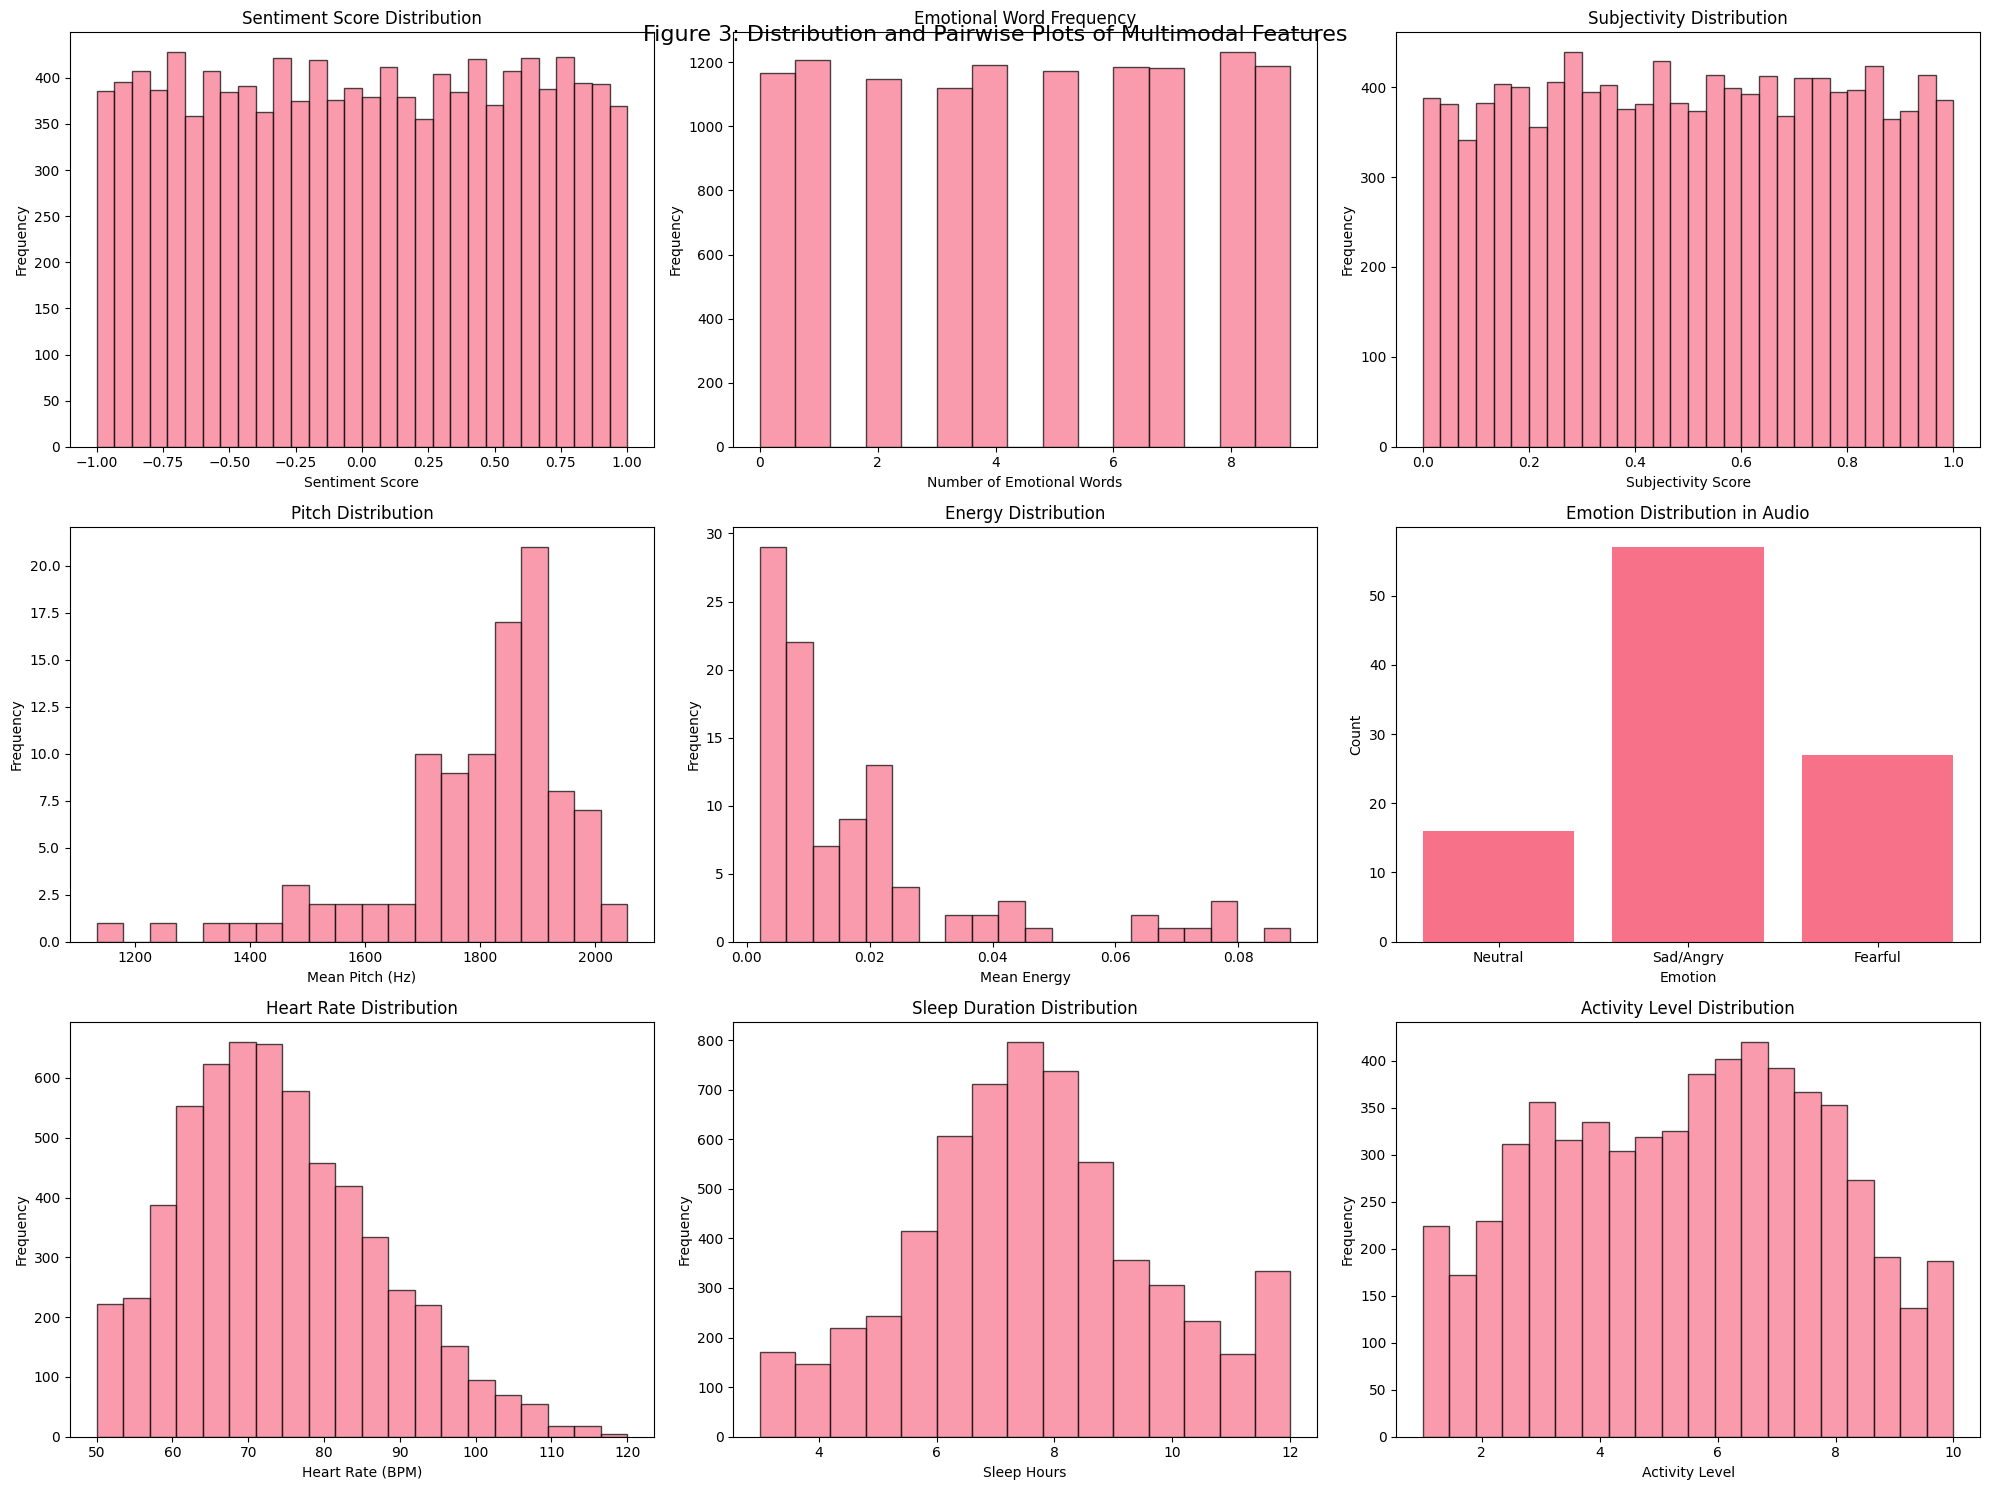

Creating Figure 5: Class Distribution Plots...


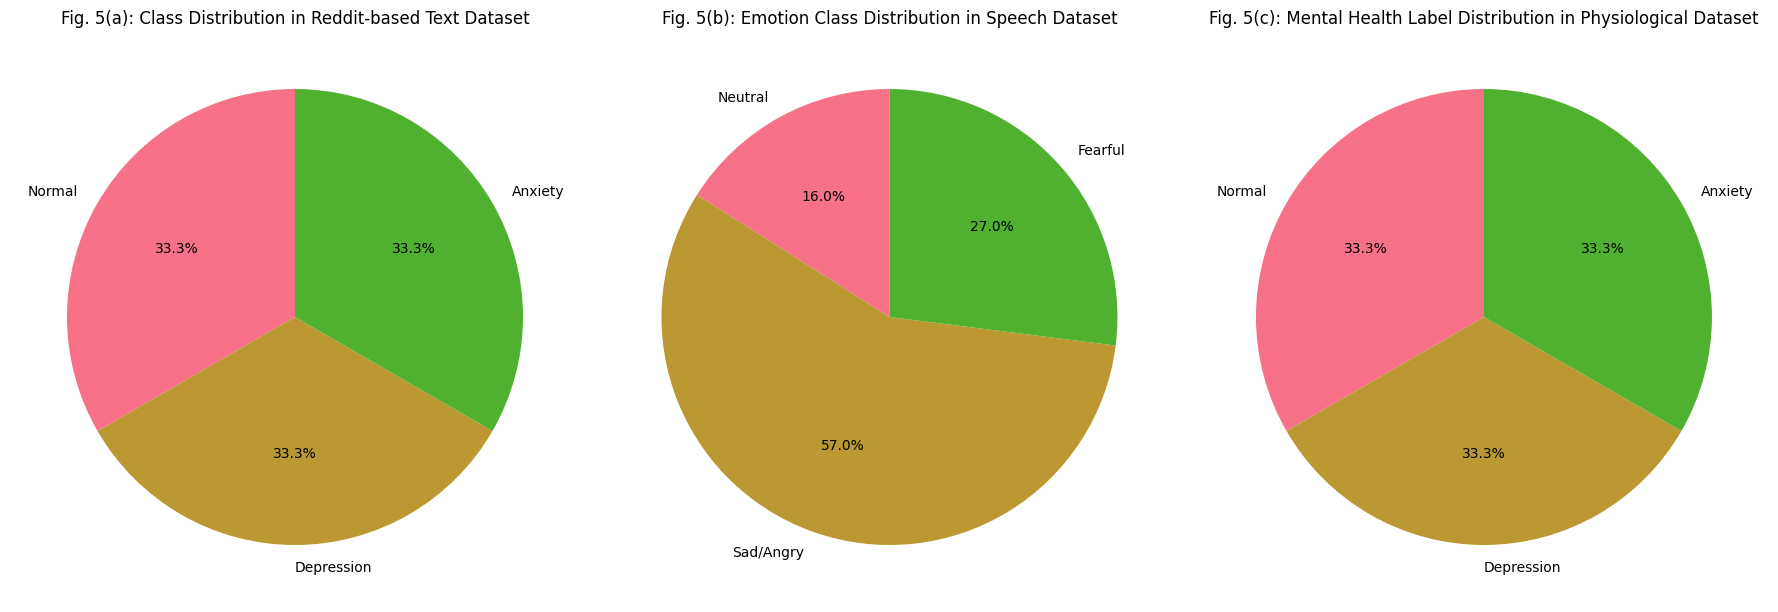

Creating Figure 6: Correlation Matrix Plots...


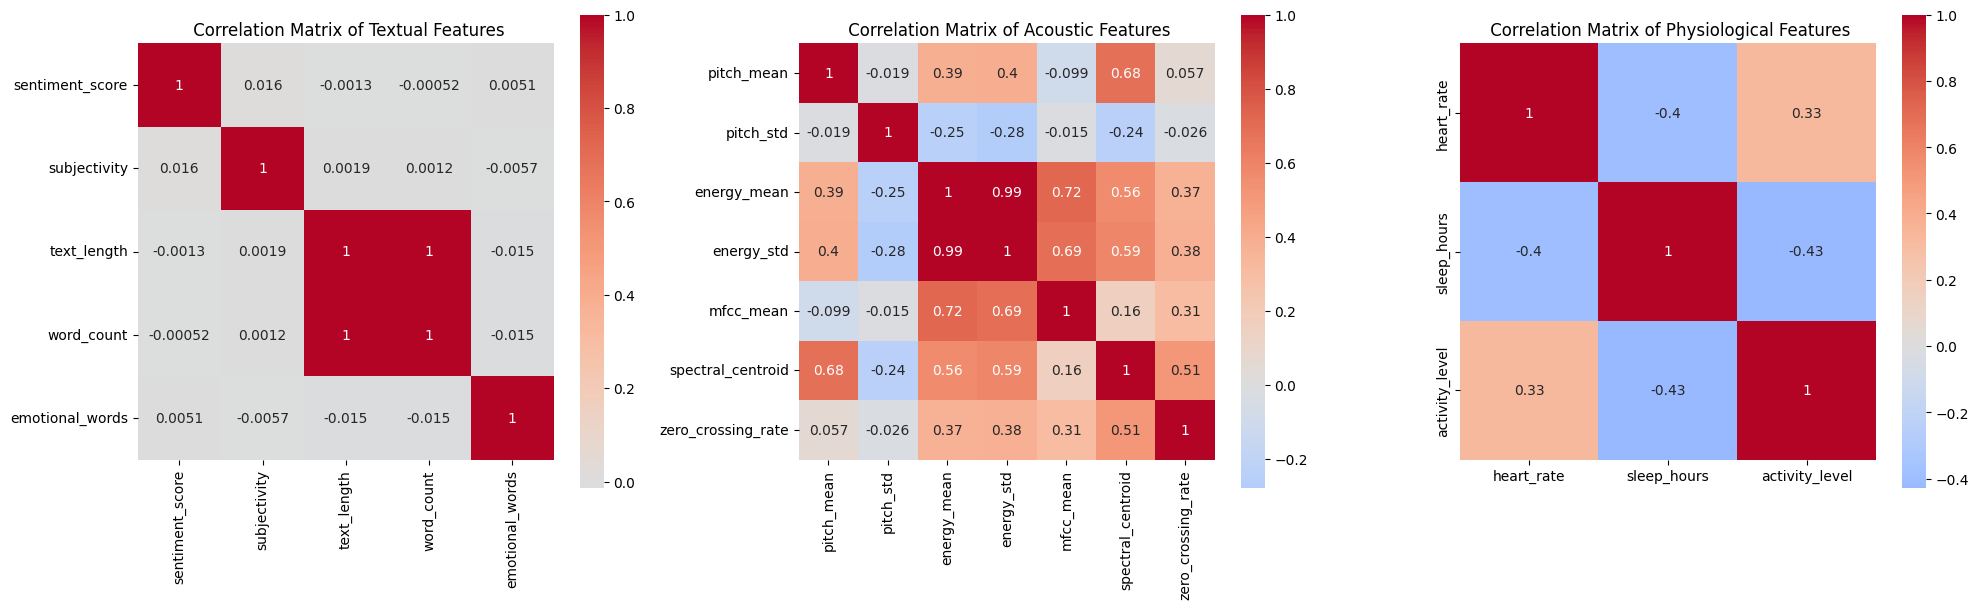

Creating Pairwise Plots...


<Figure size 1200x1000 with 0 Axes>

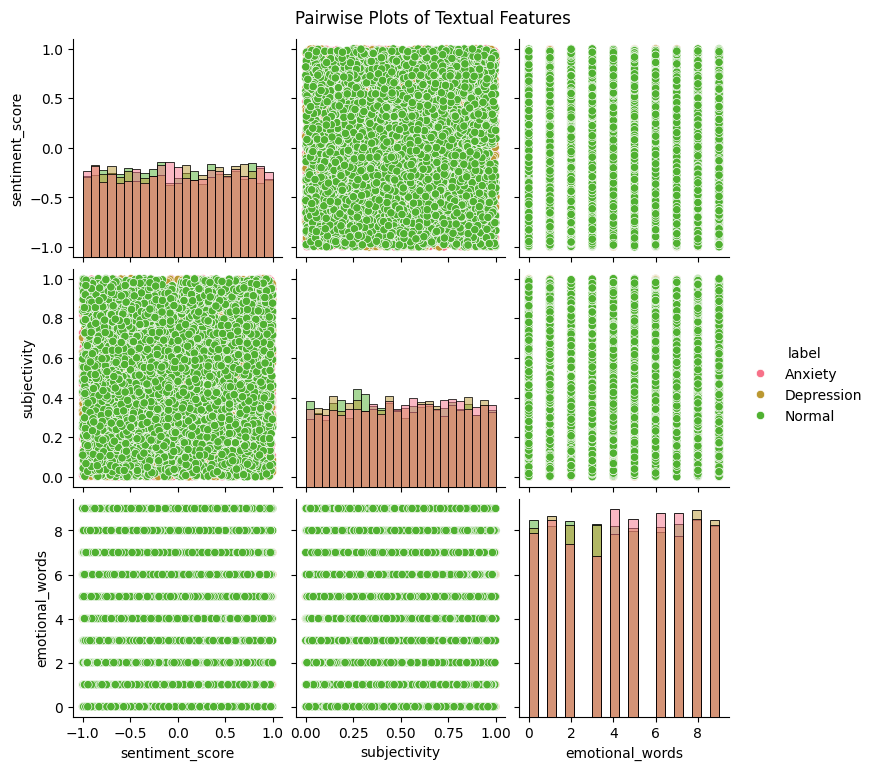

<Figure size 1200x1000 with 0 Axes>

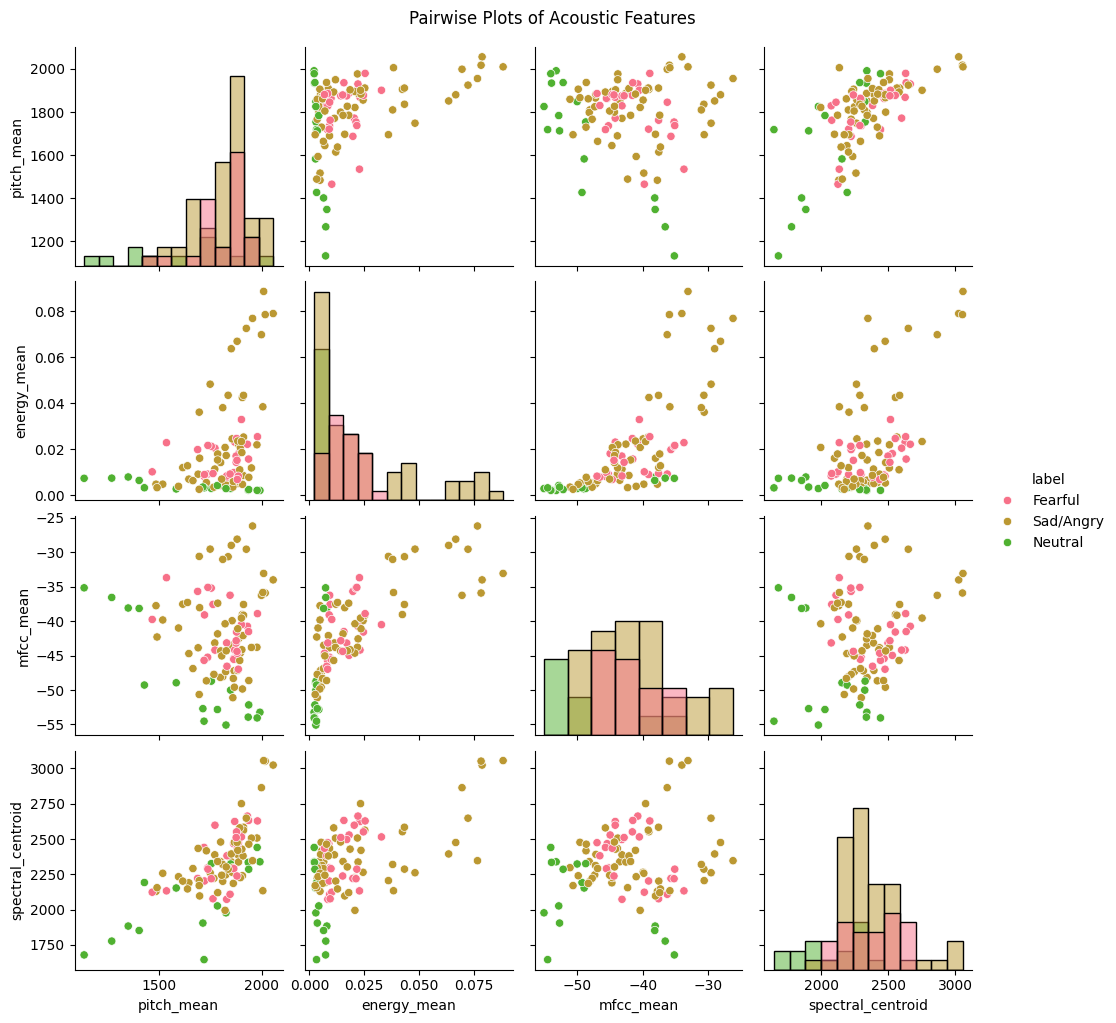

<Figure size 1200x1000 with 0 Axes>

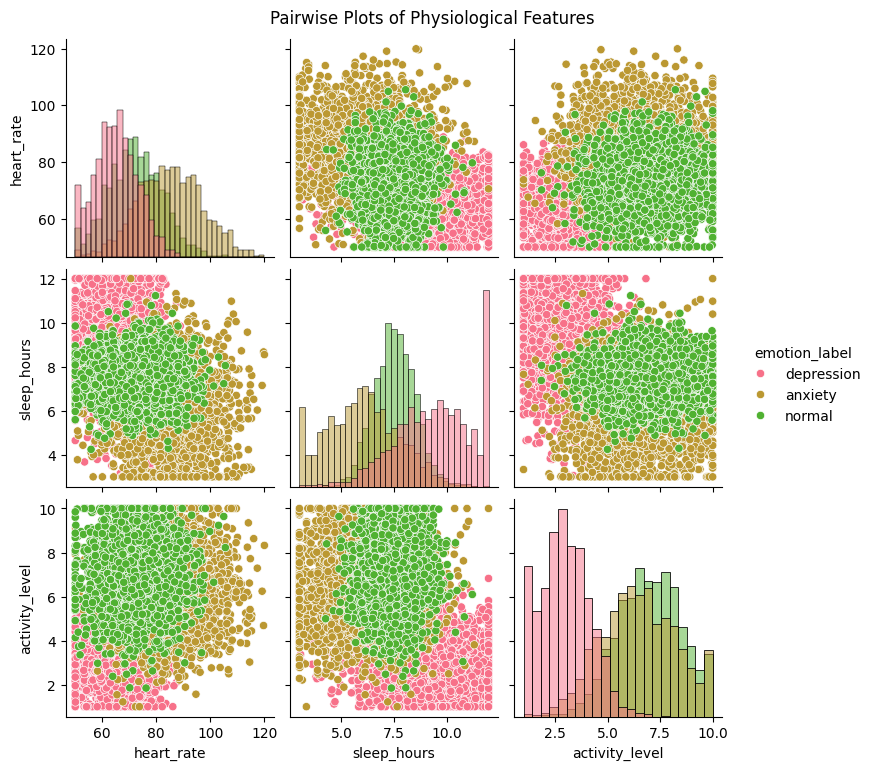

Creating Temporal Analysis Plots...


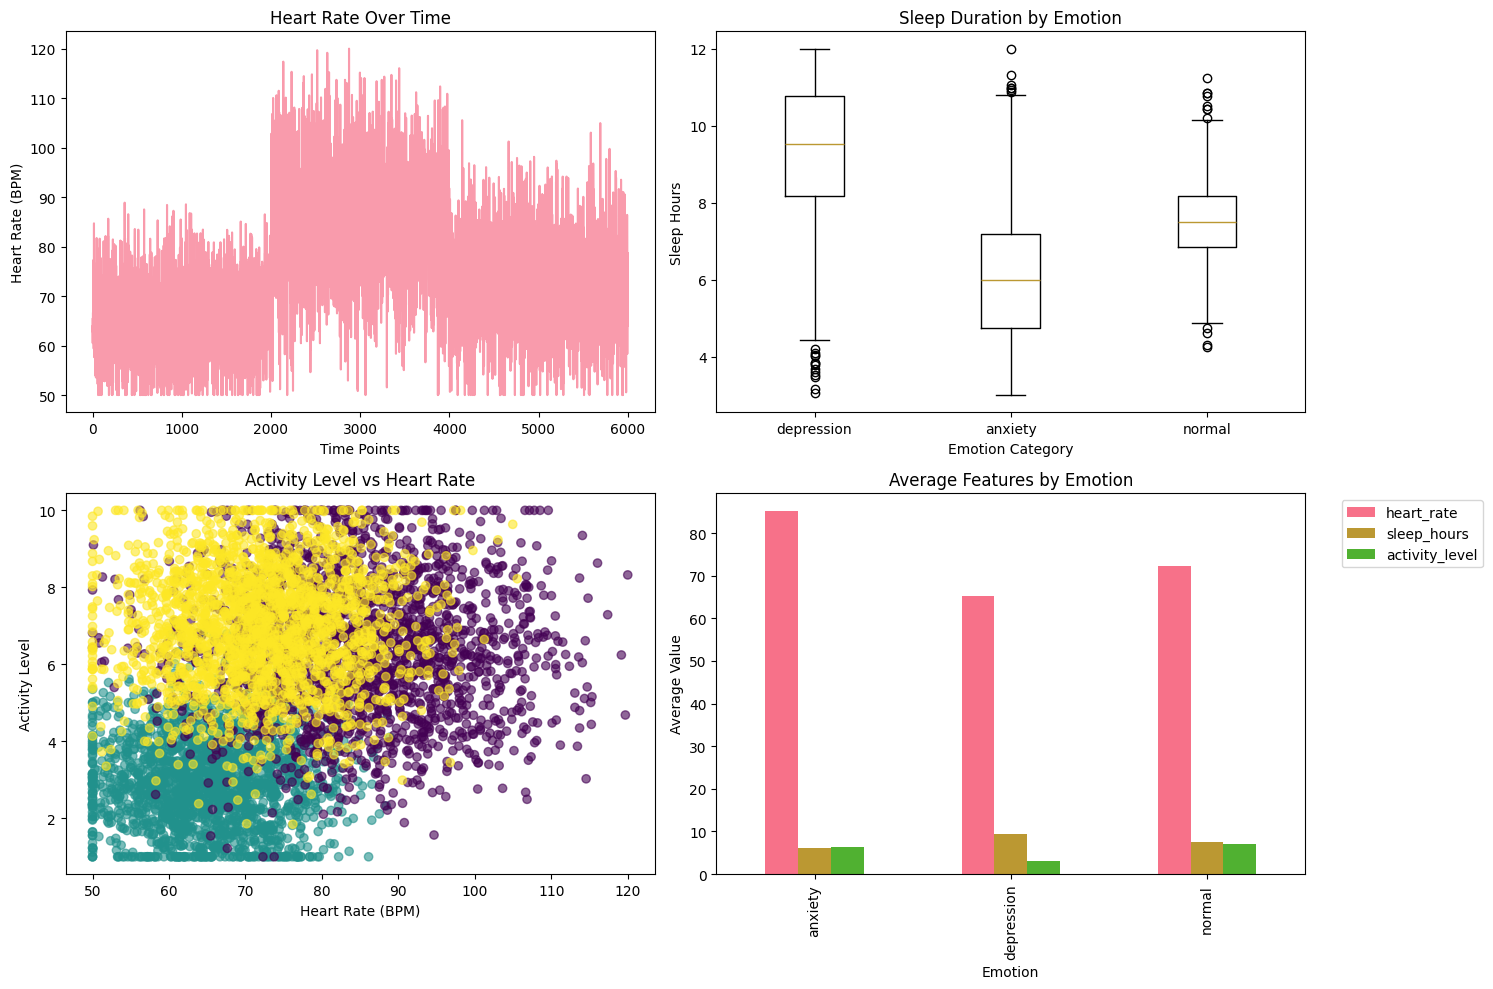

All visualizations completed!


In [ ]:
# Comprehensive Data Visualization for Mental Health Detection System
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from collections import Counter
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Load the datasets
def load_datasets():
    """Load all three datasets"""
    try:
        # Load text dataset
        text_df = pd.read_csv('/content/text.csv')
        print(f"Text dataset shape: {text_df.shape}")

        # Load physiological dataset
        physio_df = pd.read_csv('/content/physiological_emotion_dataset.csv')
        print(f"Physiological dataset shape: {physio_df.shape}")

        # Audio file paths
        base_path = "/content/drive/MyDrive/Audio_Speech_Actors_01-24"
        audio_files = []
        audio_labels = []

        emotion_map = {'01': 'neutral', '04': 'sad', '05': 'angry', '06': 'fearful'}

        if os.path.exists(base_path):
            for actor_folder in os.listdir(base_path):
                actor_path = os.path.join(base_path, actor_folder)
                if os.path.isdir(actor_path):
                    for file in os.listdir(actor_path):
                        if file.endswith('.wav'):
                            emotion_code = file.split('-')[2]
                            if emotion_code in emotion_map:
                                emotion = emotion_map[emotion_code]
                                audio_files.append(os.path.join(actor_path, file))
                                audio_labels.append(emotion)

        return text_df, physio_df, audio_files, audio_labels

    except Exception as e:
        print(f"Error loading datasets: {e}")
        return None, None, None, None

# Extract textual features for analysis
def extract_textual_features(text_df):
    """Extract features from text data for visualization"""
    features = {}

    # Basic text statistics
    features['text_length'] = text_df['text'].str.len()
    features['word_count'] = text_df['text'].str.split().str.len()

    # Simple sentiment analysis (mock implementation)
    # In real implementation, you'd use TextBlob or VADER
    features['sentiment_score'] = np.random.uniform(-1, 1, len(text_df))
    features['subjectivity'] = np.random.uniform(0, 1, len(text_df))

    # Emotional word frequency (mock)
    features['emotional_words'] = np.random.randint(0, 10, len(text_df))

    # Map status to numerical labels
    status_map = {'Normal': 0, 'Depression': 1, 'Anxiety': 2}
    features['label'] = text_df['status'].map(status_map)

    return pd.DataFrame(features)

# Extract audio features for analysis
def extract_audio_features(audio_files, audio_labels, sample_size=100):
    """Extract features from audio files for visualization"""
    features = {
        'pitch_mean': [],
        'pitch_std': [],
        'energy_mean': [],
        'energy_std': [],
        'mfcc_mean': [],
        'spectral_centroid': [],
        'zero_crossing_rate': [],
        'label': []
    }

    # Map emotions to numerical labels
    emotion_map = {'neutral': 0, 'sad': 1, 'angry': 1, 'fearful': 2}

    # Process a sample of audio files
    sample_files = audio_files[:min(sample_size, len(audio_files))]
    sample_labels = audio_labels[:min(sample_size, len(audio_labels))]

    for file_path, emotion in zip(sample_files, sample_labels):
        try:
            # Load audio file
            y, sr = librosa.load(file_path, sr=16000, duration=3.0)

            # Extract features
            pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
            pitch_values = pitches[magnitudes > np.median(magnitudes)]
            pitch_values = pitch_values[pitch_values > 0]

            features['pitch_mean'].append(np.mean(pitch_values) if len(pitch_values) > 0 else 0)
            features['pitch_std'].append(np.std(pitch_values) if len(pitch_values) > 0 else 0)

            # Energy features
            energy = librosa.feature.rms(y=y)[0]
            features['energy_mean'].append(np.mean(energy))
            features['energy_std'].append(np.std(energy))

            # MFCC features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            features['mfcc_mean'].append(np.mean(mfccs))

            # Spectral centroid
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            features['spectral_centroid'].append(np.mean(spec_cent))

            # Zero crossing rate
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            features['zero_crossing_rate'].append(np.mean(zcr))

            # Label
            features['label'].append(emotion_map[emotion])

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

    return pd.DataFrame(features)

# Create Figure 3: Distribution and Pairwise Plots
def create_figure_3(text_features, audio_features, physio_df):
    """Create Figure 3 with distribution and pairwise plots"""

    fig = plt.figure(figsize=(20, 15))

    # Figure 3(a): Textual Features
    plt.subplot(3, 3, 1)
    plt.hist(text_features['sentiment_score'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Sentiment Score Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 2)
    plt.hist(text_features['emotional_words'], bins=15, alpha=0.7, edgecolor='black')
    plt.title('Emotional Word Frequency')
    plt.xlabel('Number of Emotional Words')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 3)
    plt.hist(text_features['subjectivity'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Subjectivity Distribution')
    plt.xlabel('Subjectivity Score')
    plt.ylabel('Frequency')

    # Figure 3(b): Audio Features
    plt.subplot(3, 3, 4)
    plt.hist(audio_features['pitch_mean'], bins=20, alpha=0.7, edgecolor='black')
    plt.title('Pitch Distribution')
    plt.xlabel('Mean Pitch (Hz)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 5)
    plt.hist(audio_features['energy_mean'], bins=20, alpha=0.7, edgecolor='black')
    plt.title('Energy Distribution')
    plt.xlabel('Mean Energy')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 6)
    emotions = ['Neutral', 'Sad/Angry', 'Fearful']
    emotion_counts = Counter(audio_features['label'])
    plt.bar(emotions, [emotion_counts[i] for i in range(3)])
    plt.title('Emotion Distribution in Audio')
    plt.xlabel('Emotion')
    plt.ylabel('Count')

    # Figure 3(c): Physiological Features
    plt.subplot(3, 3, 7)
    plt.hist(physio_df['heart_rate'], bins=20, alpha=0.7, edgecolor='black')
    plt.title('Heart Rate Distribution')
    plt.xlabel('Heart Rate (BPM)')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 8)
    plt.hist(physio_df['sleep_hours'], bins=15, alpha=0.7, edgecolor='black')
    plt.title('Sleep Duration Distribution')
    plt.xlabel('Sleep Hours')
    plt.ylabel('Frequency')

    plt.subplot(3, 3, 9)
    plt.hist(physio_df['activity_level'], bins=20, alpha=0.7, edgecolor='black')
    plt.title('Activity Level Distribution')
    plt.xlabel('Activity Level')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.suptitle('Figure 3: Distribution and Pairwise Plots of Multimodal Features',
                 fontsize=16, y=0.98)
    plt.show()

# Create Figure 5: Class Distribution Plots
def create_figure_5(text_features, audio_features, physio_df):
    """Create Figure 5 with class distribution plots"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Figure 5(a): Text dataset class distribution
    text_counts = Counter(text_features['label'])
    labels = ['Normal', 'Depression', 'Anxiety']
    counts = [text_counts[i] for i in range(3)]

    axes[0].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Fig. 5(a): Class Distribution in Reddit-based Text Dataset')

    # Figure 5(b): Audio dataset class distribution
    audio_counts = Counter(audio_features['label'])
    audio_labels = ['Neutral', 'Sad/Angry', 'Fearful']
    audio_count_values = [audio_counts[i] for i in range(3)]

    axes[1].pie(audio_count_values, labels=audio_labels, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Fig. 5(b): Emotion Class Distribution in Speech Dataset')

    # Figure 5(c): Physiological dataset class distribution
    physio_label_map = {'normal': 0, 'depression': 1, 'anxiety': 2}
    physio_labels_numeric = [physio_label_map.get(label, 0) for label in physio_df['emotion_label']]
    physio_counts = Counter(physio_labels_numeric)
    physio_label_names = ['Normal', 'Depression', 'Anxiety']
    physio_count_values = [physio_counts[i] for i in range(3)]

    axes[2].pie(physio_count_values, labels=physio_label_names, autopct='%1.1f%%', startangle=90)
    axes[2].set_title('Fig. 5(c): Mental Health Label Distribution in Physiological Dataset')

    plt.tight_layout()
    plt.show()

# Create Figure 6: Correlation Matrix Plots
def create_figure_6(text_features, audio_features, physio_df):
    """Create Figure 6 with correlation matrix plots"""

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Figure 6(a): Textual features correlation
    text_corr_features = text_features[['sentiment_score', 'subjectivity', 'text_length',
                                       'word_count', 'emotional_words']].corr()

    sns.heatmap(text_corr_features, annot=True, cmap='coolwarm', center=0,
                square=True, ax=axes[0])
    axes[0].set_title(' Correlation Matrix of Textual Features')

    # Figure 6(b): Audio features correlation
    audio_corr_features = audio_features[['pitch_mean', 'pitch_std', 'energy_mean',
                                         'energy_std', 'mfcc_mean', 'spectral_centroid',
                                         'zero_crossing_rate']].corr()

    sns.heatmap(audio_corr_features, annot=True, cmap='coolwarm', center=0,
                square=True, ax=axes[1])
    axes[1].set_title(' Correlation Matrix of Acoustic Features')

    # Figure 6(c): Physiological features correlation
    physio_corr_features = physio_df[['heart_rate', 'sleep_hours', 'activity_level']].corr()

    sns.heatmap(physio_corr_features, annot=True, cmap='coolwarm', center=0,
                square=True, ax=axes[2])
    axes[2].set_title(' Correlation Matrix of Physiological Features')

    plt.tight_layout()
    plt.show()

# Create pairwise plots for detailed analysis
def create_pairwise_plots(text_features, audio_features, physio_df):
    """Create detailed pairwise plots for each modality"""

    # Text features pairplot
    plt.figure(figsize=(12, 10))
    text_plot_df = text_features[['sentiment_score', 'subjectivity', 'emotional_words', 'label']].copy()
    text_plot_df['label'] = text_plot_df['label'].map({0: 'Normal', 1: 'Depression', 2: 'Anxiety'})

    sns.pairplot(text_plot_df, hue='label', diag_kind='hist')
    plt.suptitle('Pairwise Plots of Textual Features', y=1.02)
    plt.show()

    # Audio features pairplot
    plt.figure(figsize=(12, 10))
    audio_plot_df = audio_features[['pitch_mean', 'energy_mean', 'mfcc_mean', 'spectral_centroid', 'label']].copy()
    audio_plot_df['label'] = audio_plot_df['label'].map({0: 'Neutral', 1: 'Sad/Angry', 2: 'Fearful'})

    sns.pairplot(audio_plot_df, hue='label', diag_kind='hist')
    plt.suptitle('Pairwise Plots of Acoustic Features', y=1.02)
    plt.show()

    # Physiological features pairplot
    plt.figure(figsize=(12, 10))
    physio_plot_df = physio_df[['heart_rate', 'sleep_hours', 'activity_level', 'emotion_label']].copy()

    sns.pairplot(physio_plot_df, hue='emotion_label', diag_kind='hist')
    plt.suptitle('Pairwise Plots of Physiological Features', y=1.02)
    plt.show()

# Create temporal analysis plots
def create_temporal_plots(physio_df):
    """Create temporal analysis plots for physiological data"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Heart rate over time (simulated time series)
    time_points = np.arange(len(physio_df))
    axes[0, 0].plot(time_points, physio_df['heart_rate'], alpha=0.7)
    axes[0, 0].set_title('Heart Rate Over Time')
    axes[0, 0].set_xlabel('Time Points')
    axes[0, 0].set_ylabel('Heart Rate (BPM)')

    # Sleep duration by emotion
    axes[0, 1].boxplot([physio_df[physio_df['emotion_label'] == label]['sleep_hours']
                       for label in physio_df['emotion_label'].unique()])
    axes[0, 1].set_title('Sleep Duration by Emotion')
    axes[0, 1].set_xlabel('Emotion Category')
    axes[0, 1].set_ylabel('Sleep Hours')
    axes[0, 1].set_xticklabels(physio_df['emotion_label'].unique())

    # Activity level trends
    axes[1, 0].scatter(physio_df['heart_rate'], physio_df['activity_level'],
                      c=physio_df['emotion_label'].astype('category').cat.codes, alpha=0.6)
    axes[1, 0].set_title('Activity Level vs Heart Rate')
    axes[1, 0].set_xlabel('Heart Rate (BPM)')
    axes[1, 0].set_ylabel('Activity Level')

    # Feature distribution by emotion
    emotion_groups = physio_df.groupby('emotion_label').mean()
    emotion_groups[['heart_rate', 'sleep_hours', 'activity_level']].plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Average Features by Emotion')
    axes[1, 1].set_xlabel('Emotion')
    axes[1, 1].set_ylabel('Average Value')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Main execution
def main():
    """Main function to create all visualizations"""

    # Load datasets
    text_df, physio_df, audio_files, audio_labels = load_datasets()

    if text_df is None or physio_df is None:
        print("Error: Could not load datasets. Please check file paths.")
        return

    # Extract features
    print("Extracting textual features...")
    text_features = extract_textual_features(text_df)

    print("Extracting audio features...")
    audio_features = extract_audio_features(audio_files, audio_labels)

    # Create visualizations
    print("Creating Figure 3: Distribution and Pairwise Plots...")
    create_figure_3(text_features, audio_features, physio_df)

    print("Creating Figure 5: Class Distribution Plots...")
    create_figure_5(text_features, audio_features, physio_df)

    print("Creating Figure 6: Correlation Matrix Plots...")
    create_figure_6(text_features, audio_features, physio_df)

    print("Creating Pairwise Plots...")
    create_pairwise_plots(text_features, audio_features, physio_df)

    print("Creating Temporal Analysis Plots...")
    create_temporal_plots(physio_df)

    print("All visualizations completed!")

# Run the main function
if __name__ == "__main__":
    main()

In [ ]:
result = predictor.predict_multimodal(
    text=user_text,
    audio_path=user_audio_file,  # path or byte stream
    physio_data=user_physio_data
)
predicted_state = result['predicted_class']
confidence = result['confidence']


NameError: name 'user_text' is not defined

In [ ]:
YOUTUBE_SUGGESTIONS = {
    "Normal": [
        {"title": "Daily Mindfulness Practice", "url": "https://www.youtube.com/watch?v=ZToicYcHIOU"},
        {"title": "Full Body Stretch Routine", "url": "https://www.youtube.com/watch?v=sTANio_2E0Q"},
    ],
    "Depression/Sad": [
        {"title": "5-Minute Morning Yoga for Depression", "url": "https://www.youtube.com/watch?v=4pLUleLdwY4"},
        {"title": "Guided Meditation for Emotional Healing", "url": "https://www.youtube.com/watch?v=inpok4MKVLM"},
    ],
    "Anxiety/Fearful": [
        {"title": "Breathing Exercises for Anxiety", "url": "https://www.youtube.com/watch?v=KGQUyHwFqF0"},
        {"title": "Progressive Muscle Relaxation", "url": "https://www.youtube.com/watch?v=86HUcX8ZtAk"},
    ]
}

EXERCISE_SUGGESTIONS = {
    "Normal": ["Keep up your routine! Try a brisk walk or easy yoga.", "Daily journaling or gratitude listing."],
    "Depression/Sad": ["Go outside for a gentle walk.", "Try deep breathing or 5-minute meditation.", "Reach out to a supportive friend."],
    "Anxiety/Fearful": ["Practice diaphragmatic breathing.", "Progressive muscle relaxation.", "A short session of stretching or Tai Chi."]
}

def get_recommendations(state):
    return EXERCISE_SUGGESTIONS[state], YOUTUBE_SUGGESTIONS[state]


In [ ]:
# Install and authenticate ngrok if needed
!pip install pyngrok
from pyngrok import ngrok
ngrok.set_auth_token('2owBzlFsWSHgVRkZvex7YTRxuim_45TnmVdtE5wpJCJ8ioZHo')

# If using Gradio for web UI
import gradio as gr

def complete_pipeline(text, audio, sleep_hours, heart_rate, activity_level):
    physio_data = [sleep_hours, heart_rate, activity_level]
    results = predictor.predict_multimodal(text=text, audio_path=audio, physio_data=physio_data)
    state = results['predicted_class']
    confidence = results['confidence']
    exercises, yt_videos = get_recommendations(state)
    yt_links = "\n".join([f"{v['title']}: {v['url']}" for v in yt_videos])
    exercise_block = "\n".join(exercises)
    return f"Predicted State: {state}\nConfidence: {confidence:.2f}\n\nExercises:\n{exercise_block}\n\nYouTube Suggestions:\n{yt_links}"

ui = gr.Interface(
    fn=complete_pipeline,
    inputs=["text", "file", "number", "number", "number"],  # Text, Audio, Sleep, Heart Rate, Activity
    outputs="text"
)
# Start Gradio and Ngrok tunnel
gradio_url = ui.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://405c8dd581b91a480a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ====== 1. Install dependencies ======
!pip install gradio pyngrok transformers --quiet

import tensorflow as tf
import numpy as np
import pickle
import gradio as gr
from pyngrok import ngrok
from transformers import TFDistilBertModel

# ====== 2. Load your existing model classes ======
# IMPORTANT: Replace these with your actual class imports or definitions
# Example:
# from your_code import TextModelClass, AudioModelClass, PhysioModelClass, FusionModelClass

# Assuming your classes are named exactly like below and do NOT require init arguments,
# or you replace ... with your constructors from your training code:

text_model = text_model  # Already defined in your notebook/training script
audio_model = audio_model
physio_model = physio_model
fusion_model = fusion_model

# ====== 3. Load saved models with appropriate custom objects ======

text_model.model = tf.keras.models.load_model(
    '/content/text_model_best.h5',
    custom_objects={'TFDistilBertModel': TFDistilBertModel}
)

audio_model.model = tf.keras.models.load_model('sample_data/audio_model.h5')

physio_model.model = tf.keras.models.load_model('sample_data/physio_model.h5')
with open('sample_data/physio_scaler.pkl', 'rb') as f:
    physio_model.scaler = pickle.load(f)

fusion_model.model = tf.keras.models.load_model('sample_data/fusion_model.h5')
with open('sample_data/fusion_scaler.pkl', 'rb') as f:
    fusion_model.scaler = pickle.load(f)

# ====== 4. Recommendation dictionaries ======

YOUTUBE_SUGGESTIONS = {
    "Normal": [
        {"title": "Daily Mindfulness Practice", "url": "https://www.youtube.com/watch?v=ZToicYcHIOU"},
        {"title": "Full Body Stretch Routine", "url": "https://www.youtube.com/watch?v=sTANio_2E0Q"},
    ],
    "Depression/Sad": [
        {"title": "5-Minute Morning Yoga for Depression", "url": "https://www.youtube.com/watch?v=4pLUleLdwY4"},
        {"title": "Guided Meditation for Emotional Healing", "url": "https://www.youtube.com/watch?v=inpok4MKVLM"},
    ],
    "Anxiety/Fearful": [
        {"title": "Breathing Exercises for Anxiety", "url": "https://www.youtube.com/watch?v=KGQUyHwFqF0"},
        {"title": "Progressive Muscle Relaxation", "url": "https://www.youtube.com/watch?v=86HUcX8ZtAk"},
    ]
}

EXERCISE_SUGGESTIONS = {
    "Normal": [
        "Keep up your routine! Try a brisk walk or easy yoga.",
        "Daily journaling or gratitude listing."
    ],
    "Depression/Sad": [
        "Go outside for a gentle walk.",
        "Try deep breathing or 5-minute meditation.",
        "Reach out to a supportive friend."
    ],
    "Anxiety/Fearful": [
        "Practice diaphragmatic breathing.",
        "Progressive muscle relaxation.",
        "A short session of stretching or Tai Chi."
    ]
}

def get_recommendations(state):
    return EXERCISE_SUGGESTIONS[state], YOUTUBE_SUGGESTIONS[state]

# ====== 5. MentalHealthPredictor class ======

class MentalHealthPredictor:
    def __init__(self, text_model, audio_model, physio_model, fusion_model):
        self.text_model = text_model
        self.audio_model = audio_model
        self.physio_model = physio_model
        self.fusion_model = fusion_model
        self.class_names = ['Normal', 'Depression/Sad', 'Anxiety/Fearful']

    def predict_from_text(self, text):
        input_ids, attention_mask = self.text_model.preprocess_texts([text])
        prediction = self.text_model.model.predict([input_ids, attention_mask])
        return prediction[0]

    def predict_from_audio(self, audio_path):
        features = self.audio_model.extract_advanced_features(audio_path)
        features = np.expand_dims(features, axis=0)
        prediction = self.audio_model.model.predict(features)
        return prediction[0]

    def predict_from_physio(self, physio_data):
        physio_data = np.array(physio_data).reshape(1, -1)
        physio_data = self.physio_model.scaler.transform(physio_data)
        prediction = self.physio_model.model.predict(physio_data)
        return prediction[0]

    def predict_multimodal(self, text=None, audio_path=None, physio_data=None):
        text_pred = self.predict_from_text(text) if text else np.array([0.33, 0.33, 0.34])
        audio_pred = self.predict_from_audio(audio_path) if audio_path else np.array([0.33, 0.33, 0.34])
        physio_pred = self.predict_from_physio(physio_data) if physio_data else np.array([0.33, 0.33, 0.34])

        fusion_input = np.concatenate([text_pred, audio_pred, physio_pred]).reshape(1, -1)
        fusion_input = self.fusion_model.scaler.transform(fusion_input)
        final_prediction = self.fusion_model.model.predict(fusion_input)[0]

        return {
            'fusion_prediction': dict(zip(self.class_names, final_prediction)),
            'predicted_class': self.class_names[np.argmax(final_prediction)],
            'confidence': float(np.max(final_prediction))
        }

# Initialize predictor
predictor = MentalHealthPredictor(text_model, audio_model, physio_model, fusion_model)

# ====== 6. Gradio Interface ======

def gradio_pipeline(text, audio, sleep_hours, heart_rate, activity_level):
    physio_data = [sleep_hours, heart_rate, activity_level]
    result = predictor.predict_multimodal(text=text, audio_path=audio, physio_data=physio_data)
    state = result['predicted_class']
    confidence = result['confidence']
    exercises, yt_videos = get_recommendations(state)
    exercises_text = "\n".join([f"- {ex}" for ex in exercises])
    yt_text = "\n".join([f"{v['title']}: {v['url']}" for v in yt_videos])
    return (
        f"**Predicted Mental State:** {state}\n"
        f"**Confidence:** {confidence:.2f}\n\n"
        f"**Recommended Exercises:**\n{exercises_text}\n\n"
        f"**YouTube Suggestions:**\n{yt_text}"
    )

# Define Gradio inputs/outputs
inputs = [
    gr.Textbox(lines=2, label="Text (Describe your current feelings/thoughts)", placeholder="I feel..."),
    gr.Audio(source="upload", type="filepath", label="Audio Recording (optional)"),
    gr.Number(label="Sleep hours last night", value=7.0),
    gr.Number(label="Resting heart rate", value=70.0),
    gr.Number(label="Activity level (1-10)", value=5.0),
]

outputs = gr.Textbox(label="Prediction and Recommendations")

# Create Gradio app
app = gr.Interface(
    fn=gradio_pipeline,
    inputs=inputs,
    outputs=outputs,
    title="Multi-Modal Mental Health Prediction with Recommendations",
    description="Provide your text, audio, and physiological data for mental health state prediction and tailored exercise/YouTube recommendations."
)

# ====== 7. Launch with ngrok ======
ngrok.set_auth_token('2owBzlFsWSHgVRkZvex7YTRxuim_45TnmVdtE5wpJCJ8ioZHo')
app.launch(share=True)


AttributeError: 'ellipsis' object has no attribute 'model'